In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.io import savemat, loadmat
import matlab.engine # to run Cheng's code
import time

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import my_simgraph_06 as sg
import data_handler_01 as dh

# Load spike data

Spike data shape:  (297, 1141, 113) $\implies$ (movie repeats, frames/time, neurons)
<br>
Labels are 1 (= spike) or -1 (= no spike).

In [2]:
# load all spike data from file
spikes_dp = '../../../data/original_files/spikes.csv'
binned_data = np.loadtxt(spikes_dp, delimiter=',')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1     # turn labels from 0,1 to -1,1

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

## Group all 113 neurons

This will create a more balanced dataset which is presumabley easier to solve.
<br>
Grouped data shape:  (297, 1141, 1) $\implies$ (movie repeats, frames/time, group)

In [3]:
# group all neurons together
grouped_data = np.zeros((297, 1141, 1))
for trial in range(297):
    for frame in range(1141):
        grouped_data[trial, frame, :] = 2 * int((binned_data[trial, frame, :] == 1).any()) - 1

In [4]:
# print some statistics
print('grouped_data.shape = ', grouped_data.shape)

avg_spike_perc = 0
print('trial #    | percentage belonging to class 1')
print('---------------------------------------------')
for trial in range(10):
    pers = dh.class_percentages(grouped_data[trial, :, :].reshape(-1), [-1, 1])
    avg_spike_perc += pers[1]
    print('trial #{:3} | {:.2f} %'.format(trial, pers[1]))

avg_spike_perc /= 10
print('---------------------------------------------')
print('AVERAGE     | {:.2f} %'.format(avg_spike_perc))

total_perc = np.sum(grouped_data == 1) *100 /(grouped_data.shape[0] * grouped_data.shape[1])
print('---------------------------------------------')
print('{:.2f} % of the whole data belongs to class 1.'.format(total_perc))

grouped_data.shape =  (297, 1141, 1)
trial #    | percentage belonging to class 1
---------------------------------------------
trial #  0 | 66.26 %
trial #  1 | 69.06 %
trial #  2 | 67.92 %
trial #  3 | 71.08 %
trial #  4 | 68.97 %
trial #  5 | 68.27 %
trial #  6 | 66.87 %
trial #  7 | 65.82 %
trial #  8 | 67.66 %
trial #  9 | 68.19 %
---------------------------------------------
AVERAGE     | 68.01 %
---------------------------------------------
68.47 % of the whole data belongs to class 1.


# Create training and validation datasets

In [5]:
# only consider the second trial
ind_min = 1*1141+0
ind_max = 2*1141-1
# train_num = int(data_num*0.8)
# val_num = data_num - train_num
train_num = 300
val_num = 100

def transform(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[:, ::10]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

data_params = {'func': dh.datapoint_torch, 'lbl_func': dh.get_labels, 'features_dp': '../../../data/features/slowfast/slowfast_4732/', \
               'spike_data': grouped_data, 'group_id': 0, 'transform': transform}

train_num, val_num, train_data, val_data = \
dh.random_train_val_balanced(train_num, val_num, ind_min, ind_max, data_params, seed=1342)

# show statistics
print('train_num = ', train_num, ', val_num = ', val_num)
print('# of features = ', train_data['des'].shape[1])
print('training data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(train_data['lbls'] == 1), np.sum(train_data['lbls'] == 1)*100/train_num))
print('validation data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))

# print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
# print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
# print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])

train_num =  300 , val_num =  100
# of features =  474
training data contains 150 points (50.00%) of label 1.
validation data contains 50 points (50.00%) of label 1.


## Normalize feature vectors

Taken from 'code/03_mnist/sift_on_mnist/sift_on_mnist_06.ipynb' with small changes.

In [6]:
train_dess_nrm = dh.normalize(train_data['des'], feature_nrm=1, node_nrm=30)  
val_dess_nrm = dh.normalize(val_data['des'], feature_nrm=1, node_nrm=30)

train_data['des'] = train_dess_nrm
val_data['des'] = val_dess_nrm

## snippet to update a set (training or validation)

In [7]:
# # update the validation set, so that it doesn't overlap with the training or the previous validation set
# val_num = 10
# minus_set = np.append(val_data['smpls'], train_data['smpls'])
# val_num, val_smpls = dh.update_indices(val_num, ind_min, ind_max, minus_set, seed=None)
# val_dess, val_lbls = dh.update_set(val_smpls, data_params)
# val_data   = {'des': val_dess, 'lbls': val_lbls, 'smpls': val_smpls}

# # show statistics
# print('new val_num = ', val_num)
# print('validation data contains {} points ({:.2f}%) of label 1.'
#       .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))
# # print('val_smpls = ', val_data['smpls'])
# # print('val_lbls = ', val_data['lbls'])
# # print('val_des = ', val_data['des'])

## Save the data on disc for the Matlab code's use

In [8]:
# save the dataset on disc
data_path = '../../../data/fe_exp/cheng_snap/'
savemat(data_path+'data.mat', {'train_des': train_data['des'], 'train_lbls': train_data['lbls']})

# Learn the similarity graph with GDPA

In [9]:
eng = matlab.engine.start_matlab()
eng.cd(r'/home/yasamanparhizkar/Documents/yorku/01_thesis/code/15_cheng', nargout=0)
M_gdpa = eng.gdpa_fit()
M_gdpa = np.array(M_gdpa)

starting SGML.
initial objective value = -17486.4082
converged objective value = -203230.3192
minimal eigenvalue of M = 6.9996e-06
done with SGML.


M_gdpa - Coordinates of elements with higher values than 0.0
[(0, 0), (1, 0), (11, 0), (17, 0), (21, 0), (23, 0), (25, 0), (33, 0), (44, 0), (47, 0), (0, 1), (1, 1), (2, 1), (6, 1), (8, 1), (10, 1), (12, 1), (14, 1), (18, 1), (22, 1), (26, 1), (28, 1), (30, 1), (31, 1), (34, 1), (35, 1), (37, 1), (38, 1), (40, 1), (41, 1), (43, 1), (45, 1), (46, 1), (1, 2), (2, 2), (11, 2), (17, 2), (21, 2), (23, 2), (25, 2), (33, 2), (44, 2), (47, 2), (3, 3), (4, 3), (16, 3), (20, 3), (24, 3), (36, 3), (3, 4), (4, 4), (5, 4), (7, 4), (13, 4), (15, 4), (19, 4), (27, 4), (29, 4), (32, 4), (39, 4), (4, 5), (5, 5), (16, 5), (20, 5), (24, 5), (36, 5), (1, 6), (6, 6), (11, 6), (17, 6), (21, 6), (23, 6), (25, 6), (33, 6), (44, 6), (47, 6), (4, 7), (7, 7), (16, 7), (20, 7), (24, 7), (36, 7), (1, 8), (8, 8), (11, 8), (17, 8), (21, 8), (23, 8), (25, 8), (33, 8), (44, 8), (47, 8), (9, 9), (1, 10), (10, 10), (11, 10), (17, 10), (21, 10), (23, 10), (25, 10), (33, 10), (44, 10), (47, 10), (0, 11), (2, 11), (6, 11),

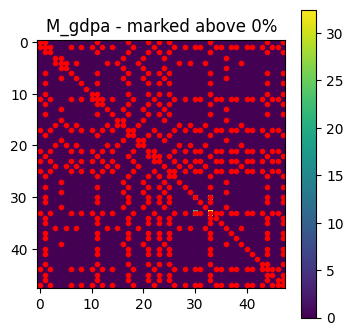

In [10]:
# display the optimized metric matrix
# print('M_gdpa = \n', M_gdpa)

sg.display_matrix(M_gdpa, None)
# mark elements with high values
thresh = 0
lim = (thresh/100) * np.max(M_gdpa) # marker threshold
f_sz = M_gdpa.shape[0]
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
plt.plot(xloc[M_gdpa > lim],yloc[M_gdpa > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M_gdpa - marked above {}%'.format(thresh))
print('M_gdpa - Coordinates of elements with higher values than {}'.format(lim))
print(list(zip(xloc[M_gdpa > lim],yloc[M_gdpa > lim])))

## Validate the similarity graph

In [11]:
# # reload sg package
# import importlib
# importlib.reload(sg)

In [12]:
# graph construction and penalty term parameters
sg_params = {'mu': 30, 'Dt': None, 'Dv': 0, 'Dvt': 2000, \
             'cnstr_method_tt': 'time', 'cnstr_method_vv': 'time', 'cnstr_method_vt': 'time',\
             'train_t': train_data['smpls'], 'val_t': val_data['smpls'], \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

val_acc_gdpa, y_est_gdpa, t_gdpa = sg.get_acc(M_gdpa, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed=0, show_edges=False)
print('Elapsed time = {:.2f} ms'.format(t_gdpa*1000))

Elapsed time = 26.48 ms


In [13]:
print('val acc = {:.2f}%'.format(val_acc_gdpa*100))
print('elapsed time = {:.2f} ms'.format(t_gdpa*1000))
print('estimated val labels = ', 2*(y_est_gdpa>0).astype(np.int32)-1)

val acc = 60.00%
elapsed time = 26.48 ms
estimated val labels =  [-1 -1 -1 -1  1 -1 -1 -1 -1 -1]


In [14]:
# comparing estimated and real spike locations
val_loc = np.arange(val_num)
val_spikes = val_loc[val_data['lbls']==1]
est_spikes_gdpa = val_loc[y_est_gdpa > 0]

if sum(val_data['lbls']==1) == 0:
    missed_gdpa = 0
else:
    missed_gdpa = sum(np.logical_and(val_data['lbls']==1, y_est_gdpa < 0))/sum(val_data['lbls']==1)

if sum(val_data['lbls']==-1) == 0:
    false_alarm_gdpa = 0
else:
    false_alarm_gdpa = sum(np.logical_and(val_data['lbls']==-1, y_est_gdpa > 0))/sum(val_data['lbls']==-1)

nospk_per = np.sum(val_data['lbls']==-1)/val_num
min_acc = max(nospk_per, 1-nospk_per)

print('Estimated spike time bins: ', est_spikes_gdpa)
print('Real spike time bins: ', val_spikes)
print('{:.2f}% of validation points have label {} (= min accuracy)'.format(min_acc*100, -1 if nospk_per > 50 else 1))
print('Missed spikes (/all spikes): {:.2f}%'.format(missed_gdpa*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_gdpa*100))

Estimated spike time bins:  [4]
Real spike time bins:  [0 1 2 3 4]
50.00% of validation points have label 1 (= min accuracy)
Missed spikes (/all spikes): 80.00%
False spikes (/all no-spike bins): 0.00%


# Train the similarity graph with M = B.T @ B

In [15]:
# graph construction and penalty term parameters
# sg_params = {'mu': 30, 'Dt': None, 'Dv':0, 'Dvt':2000, \
#              'cnstr_method_tt': 'time', 'cnstr_method_vv': 'time', 'cnstr_method_vt': 'time',\
#              'train_t': train_data['smpls'], 'val_t': val_data['smpls'], \
#              'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters
sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
                  'num_its':10, 'check_freq':1, 'print_checks':True, 'Theta0':None, \
                  'force_all_its': True, 'threshold': 0.01}

time0 = time.time()
B_fact, sg_stats_fact = sg.fit_graph(dess=train_data['des'], lbls=train_data['lbls'], graph_params=sg_params, opt_params=sg_opt_params, seed=0)
print('Elapsed time = {} sec'.format(time.time()-time0))

Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 1.95e-03;  train loss (E) = 82853.83
   1: eps = 3.91e-03;  train loss (E) = 48714.65
   2: eps = 7.81e-03;  train loss (E) = 15093.77
   3: eps = 1.56e-02;  train loss (E) = 3781.51
   4: eps = 7.81e-03;  train loss (E) = 3641.72
   5: eps = 7.81e-03;  train loss (E) = 3471.50
   6: eps = 3.91e-03;  train loss (E) = 3320.55
   7: eps = 7.81e-03;  train loss (E) = 3305.85
   8: eps = 3.91e-03;  train loss (E) = 3255.69
   9: eps = 7.81e-03;  train loss (E) = 3250.02
Elapsed time = 7.468174934387207 sec


## Display learned metric matrix

M_fact - Coordinates of elements with higher values than 4.36
[(10, 10), (22, 22), (34, 34)]


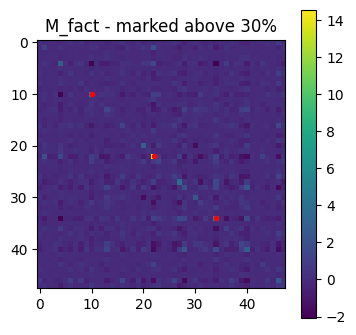

In [18]:
# display learned M
M_fact = B_fact.T @ B_fact
# to preserve memory, uncomment below line
# del B_fact

sg.display_matrix(M_fact, None)

# mark elements with high values
thresh = 30
lim = (thresh/100) * np.max(M_fact) # marker threshold
f_sz = M_fact.shape[0]
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
plt.plot(xloc[M_fact > lim],yloc[M_fact > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M_fact - marked above {}%'.format(thresh))
print('M_fact - Coordinates of elements with higher values than {:.2f}'.format(lim))
print(list(zip(xloc[M_fact > lim],yloc[M_fact > lim])))

## Validate the similarity graph

In [19]:
val_acc_fact, y_est_fact, t_fact = sg.get_acc(M_fact, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed=0, show_edges=False)

In [20]:
print('val acc = {:.2f}%'.format(val_acc_fact*100))
print('elapsed time = {:.2f} ms'.format(t_fact*1000))
print('estimated val labels = ', 2*(y_est_fact>0).astype(np.int32)-1)

val acc = 90.00%
elapsed time = 27.18 ms
estimated val labels =  [ 1 -1  1  1  1 -1 -1 -1 -1 -1]


In [21]:
# comparing estimated and real spike locations
est_spikes_fact = val_loc[y_est_fact > 0]

if sum(val_data['lbls']==1) == 0:
    missed_fact = 0
else:
    missed_fact = sum(np.logical_and(val_data['lbls']==1, y_est_fact < 0))/sum(val_data['lbls']==1)

if sum(val_data['lbls']==-1) == 0:
    false_alarm_fact = 0
else:
    false_alarm_fact = sum(np.logical_and(val_data['lbls']==-1, y_est_fact > 0))/sum(val_data['lbls']==-1)

nospk_per = np.sum(val_data['lbls']==-1)/val_num
min_acc = max(nospk_per, 1-nospk_per)

print('Estimated spike time bins: ', est_spikes_fact)
print('Real spike time bins: ', val_spikes)
print('{:.2f}% of validation points have label {} (= min accuracy)'.format(min_acc*100, -1 if nospk_per > 50 else 1))
print('Missed spikes (/all spikes): {:.2f}%'.format(missed_fact*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_fact*100))

Estimated spike time bins:  [0 2 3 4]
Real spike time bins:  [0 1 2 3 4]
50.00% of validation points have label 1 (= min accuracy)
Missed spikes (/all spikes): 20.00%
False spikes (/all no-spike bins): 0.00%


# Train the logistic regression model

In [22]:
# instantiate the model
lgrg = LogisticRegression(penalty='none')

# train the model  
lgrg = lgrg.fit(train_data['des'], train_data['lbls'])

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
# print optimized parameters
print('classes = ', lgrg.classes_)
# print('decision boundary coefficients = ', lgrg.coef_)
print('decision boundary bias = ', lgrg.intercept_)
print('number of features seen during fit = ', lgrg.n_features_in_)
print('number of iterations done during fit = ', lgrg.n_iter_)

classes =  [-1.  1.]
decision boundary bias =  [-0.05336253]
number of features seen during fit =  48
number of iterations done during fit =  [100]


## Validate the logistic regression

In [24]:
# validate the model
preds_lgrg = lgrg.predict(val_data['des'])
val_acc_lgrg = lgrg.score(val_data['des'], val_data['lbls'])

est_spikes_lgrg = val_loc[preds_lgrg > 0]
if sum(val_data['lbls']==1) == 0:
    missed_lgrg = 0
else:
    missed_lgrg = sum(np.logical_and(val_data['lbls']==1, preds_lgrg < 0))/sum(val_data['lbls']==1)
if sum(val_data['lbls']==-1) == 0:
    false_alarm_lgrg = 0
else:
    false_alarm_lgrg = sum(np.logical_and(val_data['lbls']==-1, preds_lgrg > 0))/sum(val_data['lbls']==-1)

print('Predicted labels WITH threshold =\n', preds_lgrg)
print('Validation accuracy =\n', val_acc_lgrg)
print('Estimated spike time bins: ', est_spikes_lgrg)
print('Real spike time bins: ', val_spikes)
print('Missed spikes (/all spikes): {:.2f}%'.format(missed_lgrg*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_lgrg*100))

Predicted labels WITH threshold =
 [-1. -1. -1.  1.  1. -1. -1. -1. -1. -1.]
Validation accuracy =
 0.7
Estimated spike time bins:  [3 4]
Real spike time bins:  [0 1 2 3 4]
Missed spikes (/all spikes): 60.00%
False spikes (/all no-spike bins): 0.00%


# Compare the resulting metric matrix from the two optimization processes

M_gdpa - Coordinates of elements with higher values than 0.0
[(0, 0), (1, 0), (11, 0), (17, 0), (21, 0), (23, 0), (25, 0), (33, 0), (44, 0), (47, 0), (0, 1), (1, 1), (2, 1), (6, 1), (8, 1), (10, 1), (12, 1), (14, 1), (18, 1), (22, 1), (26, 1), (28, 1), (30, 1), (31, 1), (34, 1), (35, 1), (37, 1), (38, 1), (40, 1), (41, 1), (43, 1), (45, 1), (46, 1), (1, 2), (2, 2), (11, 2), (17, 2), (21, 2), (23, 2), (25, 2), (33, 2), (44, 2), (47, 2), (3, 3), (4, 3), (16, 3), (20, 3), (24, 3), (36, 3), (3, 4), (4, 4), (5, 4), (7, 4), (13, 4), (15, 4), (19, 4), (27, 4), (29, 4), (32, 4), (39, 4), (4, 5), (5, 5), (16, 5), (20, 5), (24, 5), (36, 5), (1, 6), (6, 6), (11, 6), (17, 6), (21, 6), (23, 6), (25, 6), (33, 6), (44, 6), (47, 6), (4, 7), (7, 7), (16, 7), (20, 7), (24, 7), (36, 7), (1, 8), (8, 8), (11, 8), (17, 8), (21, 8), (23, 8), (25, 8), (33, 8), (44, 8), (47, 8), (9, 9), (1, 10), (10, 10), (11, 10), (17, 10), (21, 10), (23, 10), (25, 10), (33, 10), (44, 10), (47, 10), (0, 11), (2, 11), (6, 11),

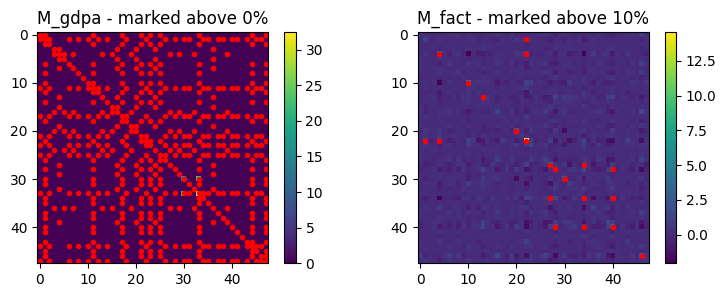

In [25]:
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.imshow(M_gdpa)
plt.colorbar()
plt.title('GDPA')
# mark elements with high values
thresh = 0
lim = (thresh/100) * np.max(M_gdpa) # marker threshold
f_sz = M_gdpa.shape[0]
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
plt.plot(xloc[M_gdpa > lim],yloc[M_gdpa > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M_gdpa - marked above {}%'.format(thresh))
print('M_gdpa - Coordinates of elements with higher values than {}'.format(lim))
print(list(zip(xloc[M_gdpa > lim],yloc[M_gdpa > lim])))


plt.subplot(1,2,2)
plt.imshow(M_fact)
plt.colorbar()
plt.title('Factorization')
# mark elements with high values
thresh = 10
lim = (thresh/100) * np.max(M_fact) # marker threshold
f_sz = M_fact.shape[0]
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
plt.plot(xloc[M_fact > lim],yloc[M_fact > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M_fact - marked above {}%'.format(thresh))
print('M_fact - Coordinates of elements with higher values than {:.2f}'.format(lim))
print(list(zip(xloc[M_fact > lim],yloc[M_fact > lim])))

In [26]:
print('GDPA val acc = {:.2f}%'.format(val_acc_gdpa*100))
print('Factorization val acc = {:.2f}%'.format(val_acc_fact*100))
print('LogReg val acc = {:.2f}%'.format(val_acc_lgrg*100))

GDPA val acc = 60.00%
Factorization val acc = 90.00%
LogReg val acc = 70.00%


In [27]:
print('Real spike time bins: ', val_spikes)
print('GDPA Estimated spike time bins: ', est_spikes_gdpa)
print('Factorization Estimated spike time bins: ', est_spikes_fact)
print('LogReg Estimated spike time bins: ', est_spikes_lgrg)

Real spike time bins:  [0 1 2 3 4]
GDPA Estimated spike time bins:  [4]
Factorization Estimated spike time bins:  [0 2 3 4]
LogReg Estimated spike time bins:  [3 4]


# Try various seeds

In [43]:
def gdpa_fact_lgrg(data_seed, val_seed_gdpa, train_seed_fact, val_seed_fact, train_num=train_num, val_num=val_num, data_params=data_params, sg_params=sg_params, sg_opt_params=sg_opt_params, lgrg=lgrg):
    # get the data
    train_num, val_num, train_data, val_data = \
    dh.random_train_val_balanced(train_num, val_num, ind_min, ind_max, data_params, seed=data_seed)

    ## GDPA
    # save the dataset on disc for Matlab's use
    data_path = '../../../data/fe_exp/cheng_snap/'
    savemat(data_path+'data.mat', {'train_des': train_data['des'], 'train_lbls': train_data['lbls']})
    time0 = time.time()
    M_gdpa = eng.gdpa_fit()
    M_gdpa = np.array(M_gdpa)
    # graph construction and penalty term parameters
    sg_params = {'mu': 30, 'Dt': None, 'Dv': 0, 'Dvt': 2000, \
                 'cnstr_method_tt': 'time', 'cnstr_method_vv': 'time', 'cnstr_method_vt': 'time',\
                 'train_t': train_data['smpls'], 'val_t': val_data['smpls'], \
                 'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }
    print('**GDPA:\nElapsed training time = {:.2f} sec'.format(time.time()-time0))
    val_acc_gdpa, y_est_gdpa, t_gdpa = sg.get_acc(M_gdpa, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed=val_seed_gdpa, show_edges=False)
    print('Elapsed validation time = {:.2f} ms'.format(t_gdpa*1000))
    # comparing estimated and real spike locations
    val_loc = np.arange(val_num)
    val_spikes = val_loc[val_data['lbls']==1]
    est_spikes_gdpa = val_loc[y_est_gdpa > 0]
    if sum(val_data['lbls']==1) == 0:
        missed_gdpa = 0
    else:
        missed_gdpa = sum(np.logical_and(val_data['lbls']==1, y_est_gdpa < 0))/sum(val_data['lbls']==1)
    if sum(val_data['lbls']==-1) == 0:
        false_alarm_gdpa = 0
    else:
        false_alarm_gdpa = sum(np.logical_and(val_data['lbls']==-1, y_est_gdpa > 0))/sum(val_data['lbls']==-1)
    nospk_per = np.sum(val_data['lbls']==-1)/val_num
    min_acc = max(nospk_per, 1-nospk_per)
    print('***')

    ## Factorization
    # gradient descent parameters
    sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
                      'num_its':10, 'check_freq':1, 'print_checks':True, 'Theta0':None, \
                      'force_all_its': True, 'threshold': 0.01}
    time0 = time.time()
    B_fact, sg_stats_fact = sg.fit_graph(dess=train_data['des'], lbls=train_data['lbls'], graph_params=sg_params, opt_params=sg_opt_params, seed=train_seed_fact)
    print('**Factorization:\nElapsed train time = {:.2f} sec'.format(time.time()-time0))
    M_fact = B_fact.T @ B_fact
    val_acc_fact, y_est_fact, t_fact = sg.get_acc(M_fact, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed=val_seed_fact, show_edges=False)
    print('Elapsed validation time = {:.2f} ms'.format(t_fact*1000))
    # comparing estimated and real spike locations
    est_spikes_fact = val_loc[y_est_fact > 0]
    if sum(val_data['lbls']==1) == 0:
        missed_fact = 0
    else:
        missed_fact = sum(np.logical_and(val_data['lbls']==1, y_est_fact < 0))/sum(val_data['lbls']==1)
    if sum(val_data['lbls']==-1) == 0:
        false_alarm_fact = 0
    else:
        false_alarm_fact = sum(np.logical_and(val_data['lbls']==-1, y_est_fact > 0))/sum(val_data['lbls']==-1)
    print('***')


    ## Logistic Regression
    # train the model
    time0 = time.time()
    lgrg = lgrg.fit(train_data['des'], train_data['lbls'])
    print('**LogReg:\nElapsed train time = {:.2f} ms'.format((time.time()-time0)*1000))
    # validate the model
    preds_lgrg = lgrg.predict(val_data['des'])
    time0 = time.time()
    val_acc_lgrg = lgrg.score(val_data['des'], val_data['lbls'])
    print('Elapsed validation time = {:.2f} ms'.format((time.time()-time0)*1000))
    est_spikes_lgrg = val_loc[preds_lgrg > 0]
    print('***')


    ## Comparisons
    print('**Comparison:')
    plt.figure(figsize=(9,3))
    plt.subplot(1,2,1)
    plt.imshow(M_gdpa)
    plt.colorbar()
    plt.title('GDPA')
    # mark elements with high values
    thresh = 0
    lim = (thresh/100) * np.max(M_gdpa) # marker threshold
    f_sz = M_gdpa.shape[0]
    xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
    yloc = xloc.T
    plt.plot(xloc[M_gdpa > lim],yloc[M_gdpa > lim], marker='o', markersize=3, color='r', linestyle='')
    plt.title('M_gdpa - marked above {}%'.format(thresh))
    print('M_gdpa - Coordinates of elements with higher values than {}'.format(lim))
    print(list(zip(xloc[M_gdpa > lim],yloc[M_gdpa > lim])))


    plt.subplot(1,2,2)
    plt.imshow(M_fact)
    plt.colorbar()
    plt.title('Factorization')
    # mark elements with high values
    thresh = 10
    lim = (thresh/100) * np.max(M_fact) # marker threshold
    f_sz = M_fact.shape[0]
    xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
    yloc = xloc.T
    plt.plot(xloc[M_fact > lim],yloc[M_fact > lim], marker='o', markersize=3, color='r', linestyle='')
    plt.title('M_fact - marked above {}%'.format(thresh))
    plt.close()
    print('M_fact - Coordinates of elements with higher values than {:.2f}'.format(lim))
    print(list(zip(xloc[M_fact > lim],yloc[M_fact > lim])))

    print('\nGDPA val acc = {:.2f}%'.format(val_acc_gdpa*100))
    print('Factorization val acc = {:.2f}%'.format(val_acc_fact*100))
    print('LogReg val acc = {:.2f}%'.format(val_acc_lgrg*100))

    print('\nReal spike time bins: ', val_spikes)
    print('GDPA estimated spike time bins: ', est_spikes_gdpa)
    print('Factorization estimated spike time bins: ', est_spikes_fact)
    print('LogReg estimated spike time bins: ', est_spikes_lgrg)

    print('\nGDPA missed spikes (/all spikes): {:.2f}%'.format(missed_gdpa*100))
    print('Factorization missed spikes (/all spikes): {:.2f}%'.format(missed_fact*100))
    print('LogReg missed spikes (/all spikes): {:.2f}%'.format(missed_lgrg*100))

    print('\nGDPA false spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_gdpa*100))
    print('Factorization false spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_fact*100))
    print('LogReg false spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_lgrg*100))

    print('\n{:.2f}% of validation points have label {} (= min accuracy)'.format(min_acc*100, -1 if nospk_per > 50 else 1))



NEW SEED == 10


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.49 sec
Elapsed validation time = 17.06 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.90 sec
Elapsed validation time = 17.54 ms
***
**LogReg:
Elapsed train time = 77.76 ms
Elapsed validation time = 0.32 ms
***
**Comparison:
M_gdpa - Coo

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


M_fact - Coordinates of elements with higher values than 1.38
[(22, 1), (4, 4), (10, 10), (22, 10), (13, 13), (20, 20), (27, 20), (40, 20), (1, 22), (10, 22), (22, 22), (20, 27), (27, 27), (34, 28), (40, 28), (30, 30), (31, 31), (28, 34), (34, 34), (39, 39), (20, 40), (28, 40), (40, 40), (43, 43), (46, 43), (43, 46), (46, 46)]

GDPA val acc = 60.00%
Factorization val acc = 80.00%
LogReg val acc = 80.00%

Real spike time bins:  [0 1 2 3 4]
GDPA estimated spike time bins:  [3]
Factorization estimated spike time bins:  [1 3 4]
LogReg estimated spike time bins:  [1 3 4]

GDPA missed spikes (/all spikes): 80.00%
Factorization missed spikes (/all spikes): 40.00%
LogReg missed spikes (/all spikes): 60.00%

GDPA false spikes (/all no-spike bins): 0.00%
Factorization false spikes (/all no-spike bins): 0.00%
LogReg false spikes (/all no-spike bins): 0.00%

50.00% of validation points have label 1 (= min accuracy)


NEW SEED == 23


starting SGML.
initial objective value = -13245.7029
converged o

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.47 sec
Elapsed validation time = 17.74 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.74 sec
Elapsed validation time = 18.31 ms
***
**LogReg:
Elapsed train time = 44.25 ms
Elapsed validation time = 0.91 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.55 sec
Elapsed validation time = 28.12 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.80 sec
Elapsed validation time = 17.03 ms
***
**LogReg:
Elapsed train time = 16.80 ms
Elapsed validation time = 0.53 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.45 sec
Elapsed validation time = 19.12 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.01 sec
Elapsed validation time = 17.23 ms
***
**LogReg:
Elapsed train time = 15.01 ms
Elapsed validation time = 0.43 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.47 sec
Elapsed validation time = 23.20 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.35 sec
Elapsed validation time = 16.70 ms
***
**LogReg:
Elapsed train time = 15.09 ms
Elapsed validation time = 0.43 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.50 sec
Elapsed validation time = 27.41 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.86 sec
Elapsed validation time = 17.18 ms
***
**LogReg:
Elapsed train time = 16.71 ms
Elapsed validation time = 0.56 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.41 sec
Elapsed validation time = 17.82 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.86 sec
Elapsed validation time = 17.21 ms
***
**LogReg:
Elapsed train time = 15.14 ms
Elapsed validation time = 0.43 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.58 sec
Elapsed validation time = 28.19 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.11 sec
Elapsed validation time = 17.13 ms
***
**LogReg:
Elapsed train time = 15.21 ms
Elapsed validation time = 0.46 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.43 sec
Elapsed validation time = 18.00 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.77 sec
Elapsed validation time = 16.67 ms
***
**LogReg:
Elapsed train time = 15.43 ms
Elapsed validation time = 0.46 ms
***
**Comparison:
M_gdpa - Coordinates of elements with higher v

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.48 sec
Elapsed validation time = 22.98 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.79 sec
Elapsed validation time = 16.91 ms
***
**LogReg:
Elapsed train time = 28.98 ms
Elapsed validation time = 0.60 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.41 sec
Elapsed validation time = 22.69 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.66 sec
Elapsed validation time = 16.70 ms
***
**LogReg:
Elapsed train time = 15.45 ms
Elapsed validation time = 0.43 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.52 sec
Elapsed validation time = 18.22 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.87 sec
Elapsed validation time = 17.43 ms
***
**LogReg:
Elapsed train time = 16.73 ms
Elapsed validation time = 0.54 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.68 sec
Elapsed validation time = 22.03 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.88 sec
Elapsed validation time = 17.44 ms
***
**LogReg:
Elapsed train time = 16.21 ms
Elapsed validation time = 0.45 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.42 sec
Elapsed validation time = 17.19 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.55 sec
Elapsed validation time = 21.73 ms
***
**LogReg:
Elapsed train time = 15.78 ms
Elapsed validation time = 0.48 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.51 sec
Elapsed validation time = 17.27 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.75 sec
Elapsed validation time = 17.85 ms
***
**LogReg:
Elapsed train time = 17.52 ms
Elapsed validation time = 0.53 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.43 sec
Elapsed validation time = 17.16 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.75 sec
Elapsed validation time = 28.00 ms
***
**LogReg:
Elapsed train time = 33.78 ms
Elapsed validation time = 0.81 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


M_fact - Coordinates of elements with higher values than 1.38
[(22, 1), (4, 4), (10, 10), (22, 10), (13, 13), (20, 20), (27, 20), (40, 20), (1, 22), (10, 22), (22, 22), (20, 27), (27, 27), (34, 28), (40, 28), (30, 30), (31, 31), (28, 34), (34, 34), (39, 39), (20, 40), (28, 40), (40, 40), (43, 43), (46, 43), (43, 46), (46, 46)]

GDPA val acc = 60.00%
Factorization val acc = 80.00%
LogReg val acc = 80.00%

Real spike time bins:  [0 1 2 3 4]
GDPA estimated spike time bins:  [3]
Factorization estimated spike time bins:  [1 3 4]
LogReg estimated spike time bins:  [1 3 4]

GDPA missed spikes (/all spikes): 80.00%
Factorization missed spikes (/all spikes): 40.00%
LogReg missed spikes (/all spikes): 60.00%

GDPA false spikes (/all no-spike bins): 0.00%
Factorization false spikes (/all no-spike bins): 0.00%
LogReg false spikes (/all no-spike bins): 0.00%

50.00% of validation points have label 1 (= min accuracy)


NEW SEED == 231


starting SGML.
initial objective value = -13245.7029
converged 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.55 sec
Elapsed validation time = 22.36 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.32 sec
Elapsed validation time = 16.83 ms
***
**LogReg:
Elapsed train time = 16.07 ms
Elapsed validation time = 0.55 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.37 sec
Elapsed validation time = 17.09 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.38 sec
Elapsed validation time = 18.64 ms
***
**LogReg:
Elapsed train time = 52.23 ms
Elapsed validation time = 0.72 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.57 sec
Elapsed validation time = 23.59 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.57 sec
Elapsed validation time = 20.02 ms
***
**LogReg:
Elapsed train time = 17.19 ms
Elapsed validation time = 0.49 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_5425/4065945038.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(9,3))


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
**GDPA:
Elapsed training time = 0.42 sec
minimal eigenvalue of M = 9.9958e-06
done with SGML.
Elapsed validation time = 19.68 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.24 sec
Elapsed validation time = 16.83 ms
***
**LogReg:
Elapsed train time = 16.49 ms
Elapsed validation time = 0.47 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.39 sec
Elapsed validation time = 17.24 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.83 sec
Elapsed validation time = 21.72 ms
***
**LogReg:
Elapsed train time = 18.65 ms
Elapsed validation time = 0.69 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.40 sec
Elapsed validation time = 17.22 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 9.82 sec
Elapsed validation time = 24.11 ms
***
**LogReg:
Elapsed train time = 90.00 ms
Elapsed validation time = 0.81 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


M_fact - Coordinates of elements with higher values than 1.38
[(22, 1), (4, 4), (10, 10), (22, 10), (13, 13), (20, 20), (27, 20), (40, 20), (1, 22), (10, 22), (22, 22), (20, 27), (27, 27), (34, 28), (40, 28), (30, 30), (31, 31), (28, 34), (34, 34), (39, 39), (20, 40), (28, 40), (40, 40), (43, 43), (46, 43), (43, 46), (46, 46)]

GDPA val acc = 60.00%
Factorization val acc = 80.00%
LogReg val acc = 80.00%

Real spike time bins:  [0 1 2 3 4]
GDPA estimated spike time bins:  [3]
Factorization estimated spike time bins:  [1 3 4]
LogReg estimated spike time bins:  [1 3 4]

GDPA missed spikes (/all spikes): 80.00%
Factorization missed spikes (/all spikes): 40.00%
LogReg missed spikes (/all spikes): 60.00%

GDPA false spikes (/all no-spike bins): 0.00%
Factorization false spikes (/all no-spike bins): 0.00%
LogReg false spikes (/all no-spike bins): 0.00%

50.00% of validation points have label 1 (= min accuracy)


NEW SEED == 322


starting SGML.
initial objective value = -13245.7029
converged 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.41 sec
Elapsed validation time = 16.79 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.70 sec
Elapsed validation time = 19.35 ms
***
**LogReg:
Elapsed train time = 36.23 ms
Elapsed validation time = 0.48 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.38 sec
Elapsed validation time = 17.42 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.92 sec
Elapsed validation time = 17.12 ms
***
**LogReg:
Elapsed train time = 14.97 ms
Elapsed validation time = 0.42 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.49 sec
Elapsed validation time = 18.02 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.75 sec
Elapsed validation time = 16.42 ms
***
**LogReg:
Elapsed train time = 16.88 ms
Elapsed validation time = 0.45 ms
***
**Comparison:
M_gdpa - Coordinates of elements with higher v

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.41 sec
Elapsed validation time = 19.12 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.52 sec
Elapsed validation time = 19.22 ms
***
**LogReg:
Elapsed train time = 20.18 ms
Elapsed validation time = 0.36 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.45 sec
Elapsed validation time = 17.80 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.67 sec
Elapsed validation time = 17.38 ms
***
**LogReg:
Elapsed train time = 15.89 ms
Elapsed validation time = 0.48 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.49 sec
Elapsed validation time = 17.31 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.67 sec
Elapsed validation time = 22.82 ms
***
**LogReg:
Elapsed train time = 22.79 ms
Elapsed validation time = 0.65 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.52 sec
Elapsed validation time = 18.49 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.28 sec
Elapsed validation time = 21.29 ms
***
**LogReg:
Elapsed train time = 25.41 ms
Elapsed validation time = 0.64 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.53 sec
Elapsed validation time = 19.77 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.81 sec
Elapsed validation time = 17.21 ms
***
**LogReg:
Elapsed train time = 18.35 ms
Elapsed validation time = 0.59 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.40 sec
Elapsed validation time = 16.94 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.32 sec
Elapsed validation time = 16.57 ms
***
**LogReg:
Elapsed train time = 17.19 ms
Elapsed validation time = 0.29 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.39 sec
Elapsed validation time = 17.55 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.81 sec
Elapsed validation time = 17.74 ms
***
**LogReg:
Elapsed train time = 15.67 ms
Elapsed validation time = 0.46 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.40 sec
Elapsed validation time = 16.97 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.71 sec
Elapsed validation time = 29.30 ms
***
**LogReg:
Elapsed train time = 57.88 ms
Elapsed validation time = 0.62 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.44 sec
Elapsed validation time = 19.21 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.41 sec
Elapsed validation time = 17.14 ms
***
**LogReg:
Elapsed train time = 14.80 ms
Elapsed validation time = 0.41 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.41 sec
Elapsed validation time = 26.87 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.07 sec
Elapsed validation time = 17.67 ms
***
**LogReg:
Elapsed train time = 17.35 ms
Elapsed validation time = 0.61 ms
***
**Comparison:
M_gdpa - Coordinates of elements with higher v

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.72 sec
Elapsed validation time = 22.23 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.29 sec
Elapsed validation time = 20.92 ms
***
**LogReg:
Elapsed train time = 65.97 ms
Elapsed validation time = 2.82 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.51 sec
Elapsed validation time = 17.19 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.55 sec
Elapsed validation time = 17.70 ms
***
**LogReg:
Elapsed train time = 17.21 ms
Elapsed validation time = 0.45 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.58 sec
Elapsed validation time = 20.01 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.44 sec
Elapsed validation time = 17.84 ms
***
**LogReg:
Elapsed train time = 15.61 ms
Elapsed validation time = 0.43 ms
***
**Comparison:
M_gdpa - Coordinates of elements with higher v

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.55 sec
Elapsed validation time = 22.49 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.15 sec
Elapsed validation time = 17.63 ms
***
**LogReg:
Elapsed train time = 18.89 ms
Elapsed validation time = 0.46 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.48 sec
Elapsed validation time = 17.52 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.91 sec
Elapsed validation time = 17.09 ms
***
**LogReg:
Elapsed train time = 16.55 ms
Elapsed validation time = 0.54 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.53 sec
Elapsed validation time = 23.26 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.85 sec
Elapsed validation time = 17.12 ms
***
**LogReg:
Elapsed train time = 16.71 ms
Elapsed validation time = 0.49 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.39 sec
Elapsed validation time = 17.05 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.50 sec
Elapsed validation time = 17.42 ms
***
**LogReg:
Elapsed train time = 17.09 ms
Elapsed validation time = 0.54 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.50 sec
Elapsed validation time = 19.48 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.86 sec
Elapsed validation time = 20.15 ms
***
**LogReg:
Elapsed train time = 101.94 ms
Elapsed validation time = 1.05 ms
***
**Comparison:
M_gdpa - Coordinates of elemen

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


M_fact - Coordinates of elements with higher values than 1.38
[(22, 1), (4, 4), (10, 10), (22, 10), (13, 13), (20, 20), (27, 20), (40, 20), (1, 22), (10, 22), (22, 22), (20, 27), (27, 27), (34, 28), (40, 28), (30, 30), (31, 31), (28, 34), (34, 34), (39, 39), (20, 40), (28, 40), (40, 40), (43, 43), (46, 43), (43, 46), (46, 46)]

GDPA val acc = 60.00%
Factorization val acc = 80.00%
LogReg val acc = 80.00%

Real spike time bins:  [0 1 2 3 4]
GDPA estimated spike time bins:  [3]
Factorization estimated spike time bins:  [1 3 4]
LogReg estimated spike time bins:  [1 3 4]

GDPA missed spikes (/all spikes): 80.00%
Factorization missed spikes (/all spikes): 40.00%
LogReg missed spikes (/all spikes): 60.00%

GDPA false spikes (/all no-spike bins): 0.00%
Factorization false spikes (/all no-spike bins): 0.00%
LogReg false spikes (/all no-spike bins): 0.00%

50.00% of validation points have label 1 (= min accuracy)


NEW SEED == 608


starting SGML.
initial objective value = -13245.7029
converged 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.60 sec
Elapsed validation time = 18.46 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 9.35 sec
Elapsed validation time = 19.62 ms
***
**LogReg:
Elapsed train time = 47.30 ms
Elapsed validation time = 0.59 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.78 sec
Elapsed validation time = 20.57 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.83 sec
Elapsed validation time = 19.15 ms
***
**LogReg:
Elapsed train time = 71.64 ms
Elapsed validation time = 0.31 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


M_fact - Coordinates of elements with higher values than 1.38
[(22, 1), (4, 4), (10, 10), (22, 10), (13, 13), (20, 20), (27, 20), (40, 20), (1, 22), (10, 22), (22, 22), (20, 27), (27, 27), (34, 28), (40, 28), (30, 30), (31, 31), (28, 34), (34, 34), (39, 39), (20, 40), (28, 40), (40, 40), (43, 43), (46, 43), (43, 46), (46, 46)]

GDPA val acc = 60.00%
Factorization val acc = 80.00%
LogReg val acc = 80.00%

Real spike time bins:  [0 1 2 3 4]
GDPA estimated spike time bins:  [3]
Factorization estimated spike time bins:  [1 3 4]
LogReg estimated spike time bins:  [1 3 4]

GDPA missed spikes (/all spikes): 80.00%
Factorization missed spikes (/all spikes): 40.00%
LogReg missed spikes (/all spikes): 60.00%

GDPA false spikes (/all no-spike bins): 0.00%
Factorization false spikes (/all no-spike bins): 0.00%
LogReg false spikes (/all no-spike bins): 0.00%

50.00% of validation points have label 1 (= min accuracy)


NEW SEED == 647


starting SGML.
initial objective value = -13245.7029
converged 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.51 sec
Elapsed validation time = 19.09 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.98 sec
Elapsed validation time = 17.84 ms
***
**LogReg:
Elapsed train time = 15.71 ms
Elapsed validation time = 0.57 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.45 sec
Elapsed validation time = 18.43 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.05 sec
Elapsed validation time = 17.54 ms
***
**LogReg:
Elapsed train time = 15.60 ms
Elapsed validation time = 0.53 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.50 sec
Elapsed validation time = 19.08 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.65 sec
Elapsed validation time = 17.55 ms
***
**LogReg:
Elapsed train time = 15.67 ms
Elapsed validation time = 0.50 ms
***
**Comparison:
M_gdpa - Coordinates of elements with higher v

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.43 sec
Elapsed validation time = 17.97 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.35 sec
Elapsed validation time = 17.88 ms
***
**LogReg:
Elapsed train time = 149.06 ms
Elapsed validation time = 1.87 ms
***
**Comparison:


/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


M_gdpa - Coordinates of elements with higher values than 0.0
[(0, 0), (1, 1), (17, 1), (21, 1), (23, 1), (25, 1), (29, 1), (31, 1), (33, 1), (41, 1), (43, 1), (45, 1), (2, 2), (3, 3), (20, 3), (24, 3), (28, 3), (32, 3), (34, 3), (36, 3), (42, 3), (44, 3), (4, 4), (20, 4), (24, 4), (28, 4), (32, 4), (34, 4), (36, 4), (42, 4), (44, 4), (5, 5), (20, 5), (24, 5), (28, 5), (32, 5), (34, 5), (36, 5), (42, 5), (44, 5), (6, 6), (17, 6), (21, 6), (23, 6), (25, 6), (29, 6), (31, 6), (33, 6), (41, 6), (43, 6), (45, 6), (7, 7), (8, 8), (17, 8), (21, 8), (23, 8), (25, 8), (29, 8), (31, 8), (33, 8), (41, 8), (43, 8), (45, 8), (9, 9), (10, 10), (20, 10), (24, 10), (28, 10), (32, 10), (34, 10), (36, 10), (42, 10), (44, 10), (11, 11), (12, 12), (17, 12), (21, 12), (23, 12), (25, 12), (29, 12), (31, 12), (33, 12), (41, 12), (43, 12), (45, 12), (13, 13), (20, 13), (24, 13), (28, 13), (32, 13), (34, 13), (36, 13), (42, 13), (44, 13), (14, 14), (17, 14), (21, 14), (23, 14), (25, 14), (29, 14), (31, 14), (3

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.51 sec
Elapsed validation time = 18.60 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.22 sec
Elapsed validation time = 22.97 ms
***
**LogReg:
Elapsed train time = 42.18 ms
Elapsed validation time = 0.33 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.48 sec
Elapsed validation time = 24.59 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.50 sec
Elapsed validation time = 17.96 ms
***
**LogReg:
Elapsed train time = 17.21 ms
Elapsed validation time = 0.61 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.54 sec
Elapsed validation time = 23.03 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.84 sec
Elapsed validation time = 21.25 ms
***
**LogReg:
Elapsed train time = 73.18 ms
Elapsed validation time = 0.36 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.64 sec
Elapsed validation time = 19.94 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 9.22 sec
Elapsed validation time = 27.54 ms
***
**LogReg:
Elapsed train time = 85.79 ms
Elapsed validation time = 0.57 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.51 sec
Elapsed validation time = 20.48 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.13 sec
Elapsed validation time = 18.67 ms
***
**LogReg:
Elapsed train time = 40.60 ms
Elapsed validation time = 1.45 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.43 sec
Elapsed validation time = 19.45 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.21 sec
Elapsed validation time = 18.60 ms
***
**LogReg:
Elapsed train time = 17.87 ms
Elapsed validation time = 0.60 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.48 sec
Elapsed validation time = 19.83 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.71 sec
Elapsed validation time = 21.40 ms
***
**LogReg:
Elapsed train time = 34.69 ms
Elapsed validation time = 0.54 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.47 sec
Elapsed validation time = 17.99 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.26 sec
Elapsed validation time = 23.27 ms
***
**LogReg:
Elapsed train time = 37.07 ms
Elapsed validation time = 0.54 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.52 sec
Elapsed validation time = 27.76 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 9.82 sec
Elapsed validation time = 21.29 ms
***
**LogReg:
Elapsed train time = 24.00 ms
Elapsed validation time = 0.66 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.55 sec
Elapsed validation time = 23.06 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.43 sec
Elapsed validation time = 21.90 ms
***
**LogReg:
Elapsed train time = 112.84 ms
Elapsed validation time = 0.36 ms
***
**Comparison:
M_gdpa - Coordinates of elemen

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


M_fact - Coordinates of elements with higher values than 1.38
[(22, 1), (4, 4), (10, 10), (22, 10), (13, 13), (20, 20), (27, 20), (40, 20), (1, 22), (10, 22), (22, 22), (20, 27), (27, 27), (34, 28), (40, 28), (30, 30), (31, 31), (28, 34), (34, 34), (39, 39), (20, 40), (28, 40), (40, 40), (43, 43), (46, 43), (43, 46), (46, 46)]

GDPA val acc = 60.00%
Factorization val acc = 80.00%
LogReg val acc = 80.00%

Real spike time bins:  [0 1 2 3 4]
GDPA estimated spike time bins:  [3]
Factorization estimated spike time bins:  [1 3 4]
LogReg estimated spike time bins:  [1 3 4]

GDPA missed spikes (/all spikes): 80.00%
Factorization missed spikes (/all spikes): 40.00%
LogReg missed spikes (/all spikes): 60.00%

GDPA false spikes (/all no-spike bins): 0.00%
Factorization false spikes (/all no-spike bins): 0.00%
LogReg false spikes (/all no-spike bins): 0.00%

50.00% of validation points have label 1 (= min accuracy)


NEW SEED == 855


starting SGML.
initial objective value = -13245.7029
converged 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.46 sec
Elapsed validation time = 20.30 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.42 sec
Elapsed validation time = 18.77 ms
***
**LogReg:
Elapsed train time = 47.66 ms
Elapsed validation time = 1.40 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.47 sec
Elapsed validation time = 20.01 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.13 sec
Elapsed validation time = 18.47 ms
***


/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**LogReg:
Elapsed train time = 293.84 ms
Elapsed validation time = 0.35 ms
***
**Comparison:
M_gdpa - Coordinates of elements with higher values than 0.0
[(0, 0), (1, 1), (17, 1), (21, 1), (23, 1), (25, 1), (29, 1), (31, 1), (33, 1), (41, 1), (43, 1), (45, 1), (2, 2), (3, 3), (20, 3), (24, 3), (28, 3), (32, 3), (34, 3), (36, 3), (42, 3), (44, 3), (4, 4), (20, 4), (24, 4), (28, 4), (32, 4), (34, 4), (36, 4), (42, 4), (44, 4), (5, 5), (20, 5), (24, 5), (28, 5), (32, 5), (34, 5), (36, 5), (42, 5), (44, 5), (6, 6), (17, 6), (21, 6), (23, 6), (25, 6), (29, 6), (31, 6), (33, 6), (41, 6), (43, 6), (45, 6), (7, 7), (8, 8), (17, 8), (21, 8), (23, 8), (25, 8), (29, 8), (31, 8), (33, 8), (41, 8), (43, 8), (45, 8), (9, 9), (10, 10), (20, 10), (24, 10), (28, 10), (32, 10), (34, 10), (36, 10), (42, 10), (44, 10), (11, 11), (12, 12), (17, 12), (21, 12), (23, 12), (25, 12), (29, 12), (31, 12), (33, 12), (41, 12), (43, 12), (45, 12), (13, 13), (20, 13), (24, 13), (28, 13), (32, 13), (34, 13), (36, 13),

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.44 sec
Elapsed validation time = 18.45 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.98 sec
Elapsed validation time = 18.46 ms
***
**LogReg:
Elapsed train time = 18.90 ms
Elapsed validation time = 0.33 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.44 sec
Elapsed validation time = 18.95 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.77 sec
Elapsed validation time = 17.18 ms
***
**LogReg:
Elapsed train time = 111.17 ms
Elapsed validation time = 1.55 ms
***
**Comparison:


/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


M_gdpa - Coordinates of elements with higher values than 0.0
[(0, 0), (1, 1), (17, 1), (21, 1), (23, 1), (25, 1), (29, 1), (31, 1), (33, 1), (41, 1), (43, 1), (45, 1), (2, 2), (3, 3), (20, 3), (24, 3), (28, 3), (32, 3), (34, 3), (36, 3), (42, 3), (44, 3), (4, 4), (20, 4), (24, 4), (28, 4), (32, 4), (34, 4), (36, 4), (42, 4), (44, 4), (5, 5), (20, 5), (24, 5), (28, 5), (32, 5), (34, 5), (36, 5), (42, 5), (44, 5), (6, 6), (17, 6), (21, 6), (23, 6), (25, 6), (29, 6), (31, 6), (33, 6), (41, 6), (43, 6), (45, 6), (7, 7), (8, 8), (17, 8), (21, 8), (23, 8), (25, 8), (29, 8), (31, 8), (33, 8), (41, 8), (43, 8), (45, 8), (9, 9), (10, 10), (20, 10), (24, 10), (28, 10), (32, 10), (34, 10), (36, 10), (42, 10), (44, 10), (11, 11), (12, 12), (17, 12), (21, 12), (23, 12), (25, 12), (29, 12), (31, 12), (33, 12), (41, 12), (43, 12), (45, 12), (13, 13), (20, 13), (24, 13), (28, 13), (32, 13), (34, 13), (36, 13), (42, 13), (44, 13), (14, 14), (17, 14), (21, 14), (23, 14), (25, 14), (29, 14), (31, 14), (3

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.51 sec
Elapsed validation time = 18.77 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.39 sec
Elapsed validation time = 19.90 ms
***
**LogReg:
Elapsed train time = 53.44 ms
Elapsed validation time = 0.37 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


M_fact - Coordinates of elements with higher values than 1.38
[(22, 1), (4, 4), (10, 10), (22, 10), (13, 13), (20, 20), (27, 20), (40, 20), (1, 22), (10, 22), (22, 22), (20, 27), (27, 27), (34, 28), (40, 28), (30, 30), (31, 31), (28, 34), (34, 34), (39, 39), (20, 40), (28, 40), (40, 40), (43, 43), (46, 43), (43, 46), (46, 46)]

GDPA val acc = 60.00%
Factorization val acc = 80.00%
LogReg val acc = 80.00%

Real spike time bins:  [0 1 2 3 4]
GDPA estimated spike time bins:  [3]
Factorization estimated spike time bins:  [1 3 4]
LogReg estimated spike time bins:  [1 3 4]

GDPA missed spikes (/all spikes): 80.00%
Factorization missed spikes (/all spikes): 40.00%
LogReg missed spikes (/all spikes): 60.00%

GDPA false spikes (/all no-spike bins): 0.00%
Factorization false spikes (/all no-spike bins): 0.00%
LogReg false spikes (/all no-spike bins): 0.00%

50.00% of validation points have label 1 (= min accuracy)


NEW SEED == 959


starting SGML.
initial objective value = -13245.7029
converged 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.45 sec
Elapsed validation time = 18.03 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.20 sec
Elapsed validation time = 22.23 ms
***
**LogReg:
Elapsed train time = 19.63 ms
Elapsed validation time = 0.56 ms
***
**Comparison:
M_gdpa - Coordinates of elements with higher v

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.49 sec
Elapsed validation time = 18.84 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 8.56 sec
Elapsed validation time = 19.50 ms
***
**LogReg:
Elapsed train time = 45.13 ms
Elapsed validation time = 0.50 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.55 sec
Elapsed validation time = 20.21 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 9.00 sec
Elapsed validation time = 18.85 ms
***
**LogReg:
Elapsed train time = 20.92 ms
Elapsed validation time = 0.34 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


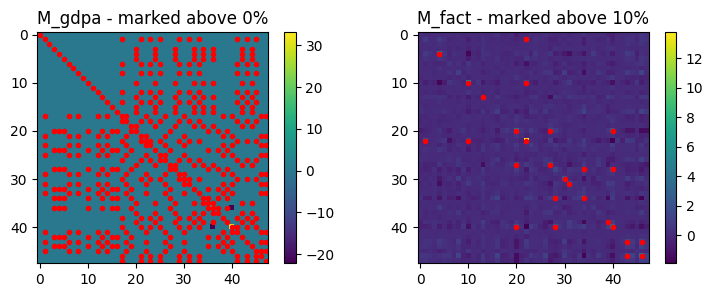

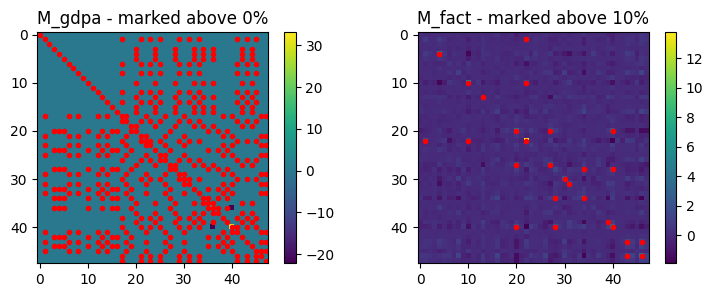

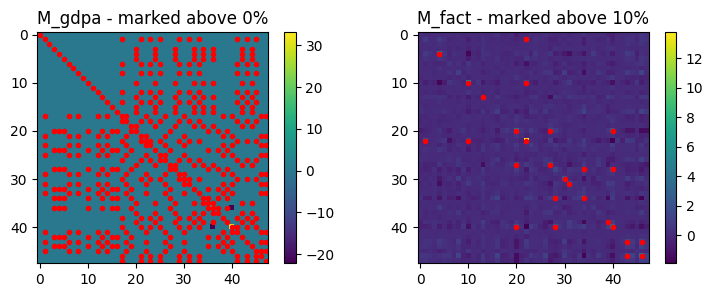

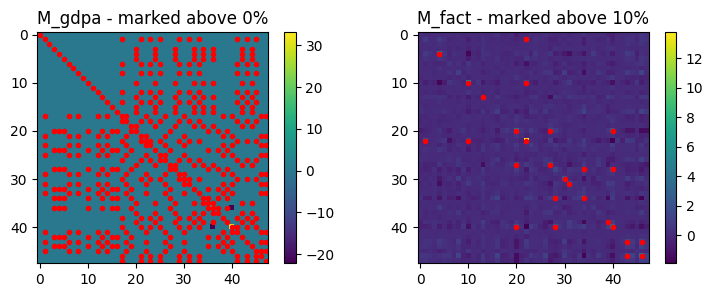

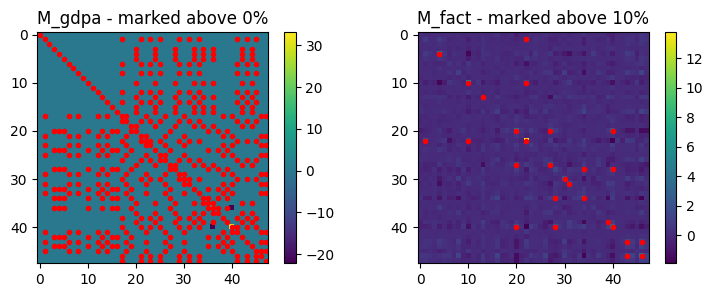

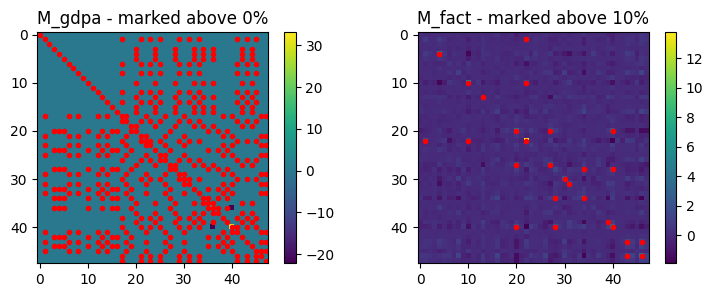

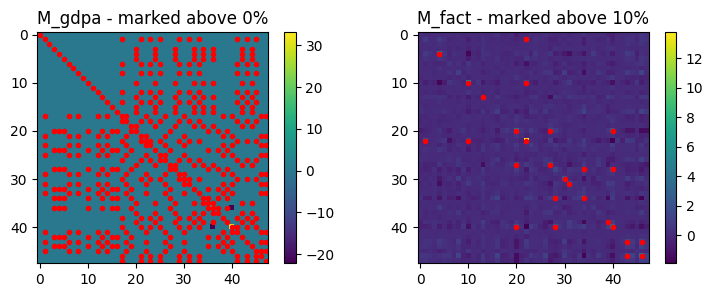

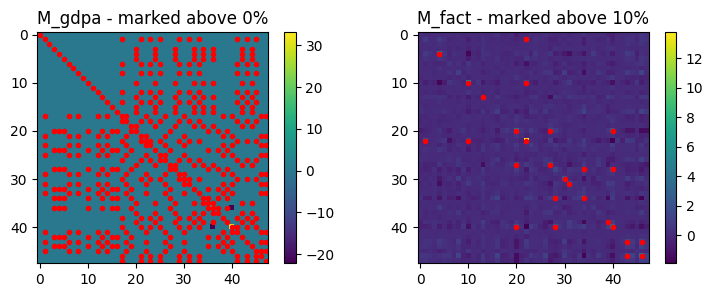

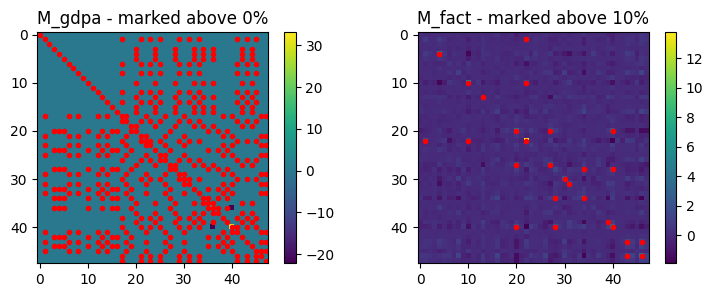

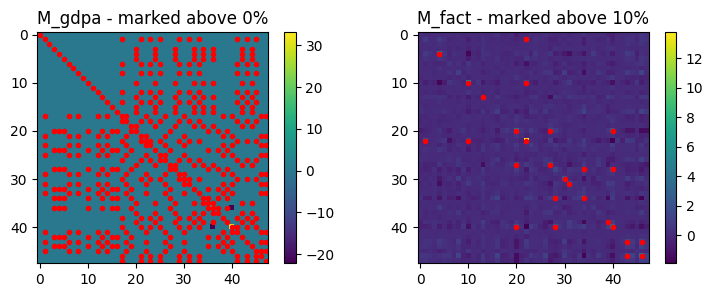

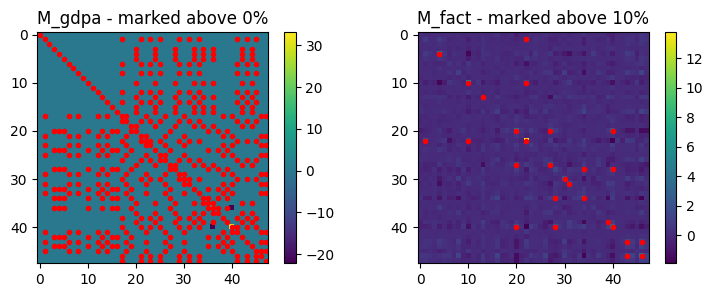

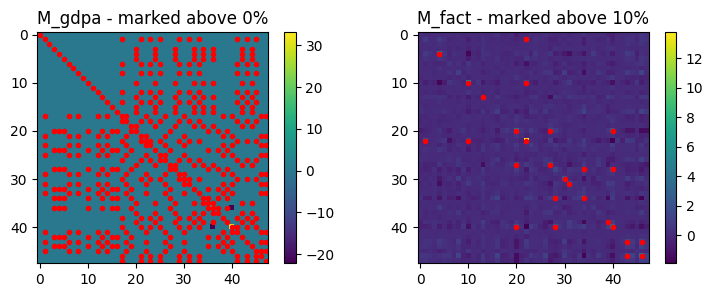

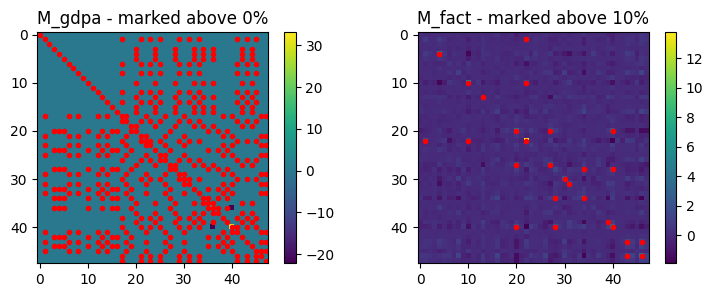

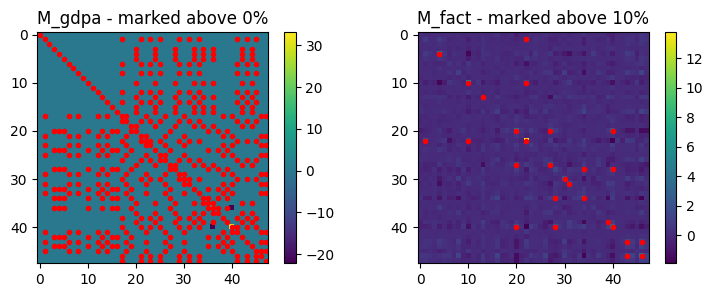

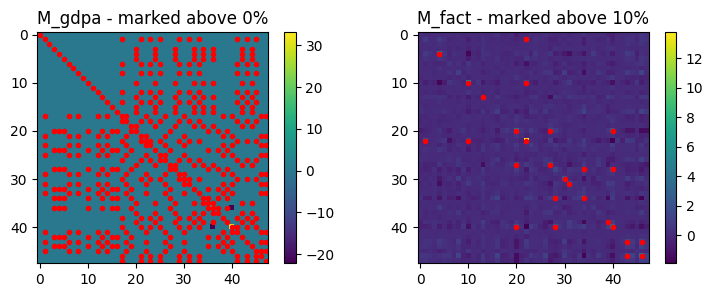

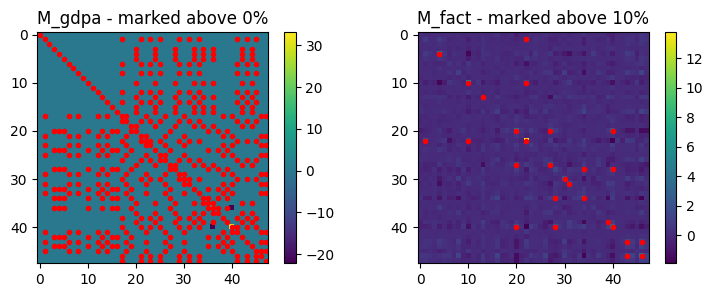

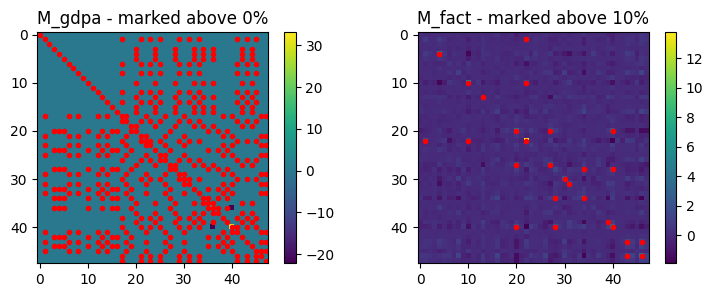

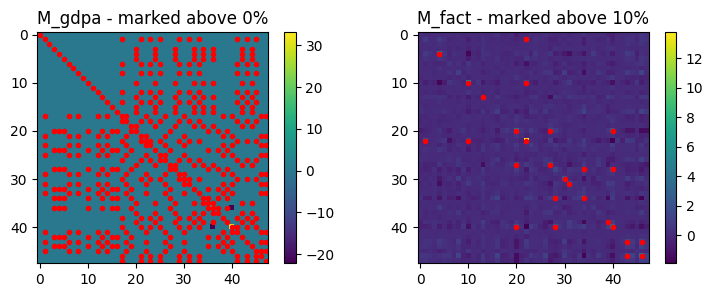

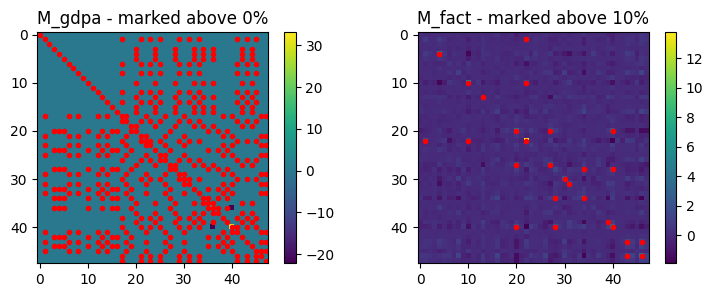

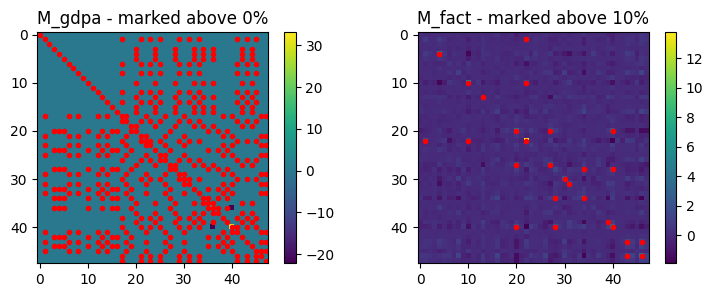

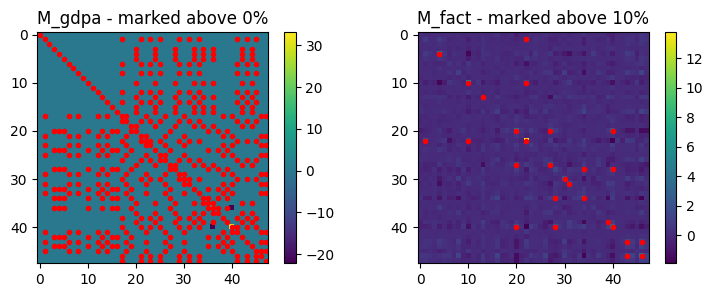

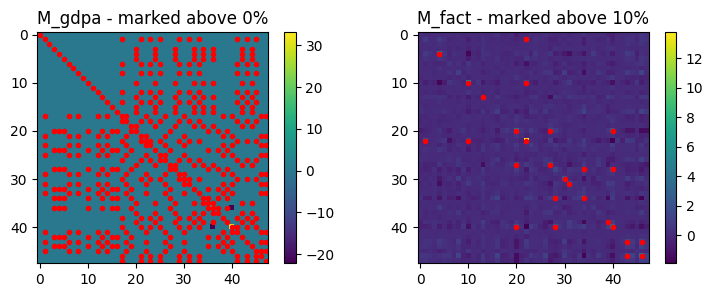

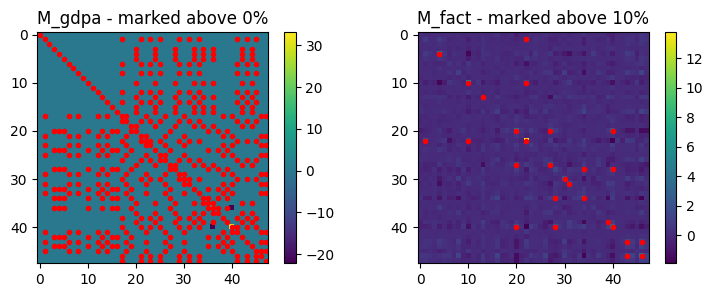

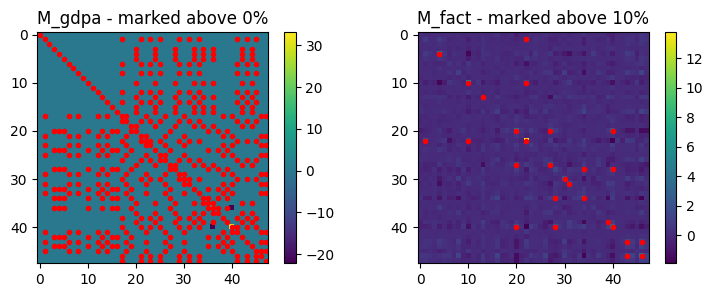

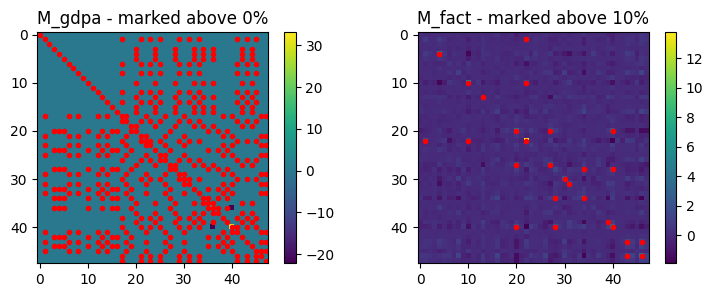

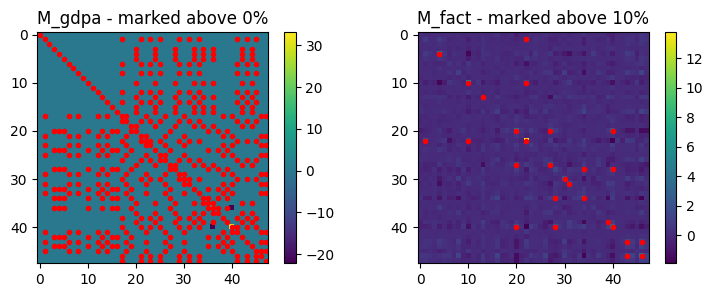

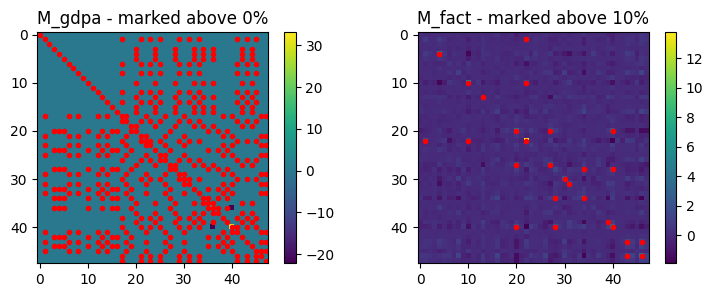

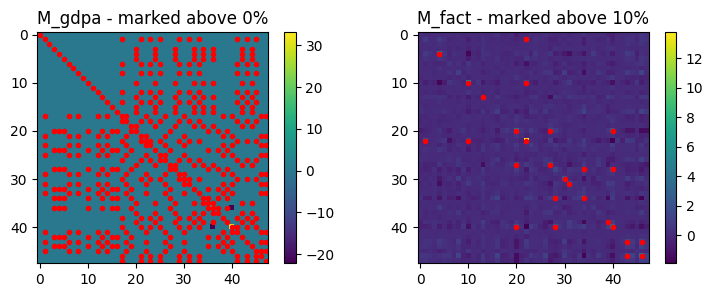

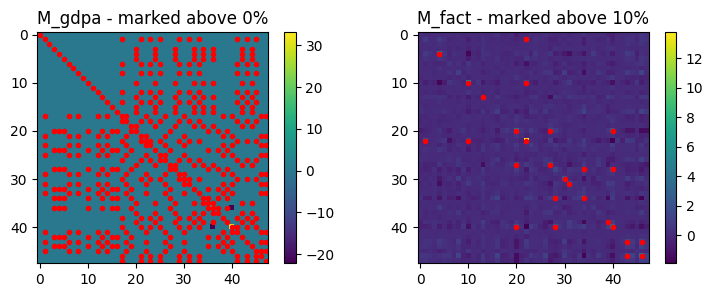

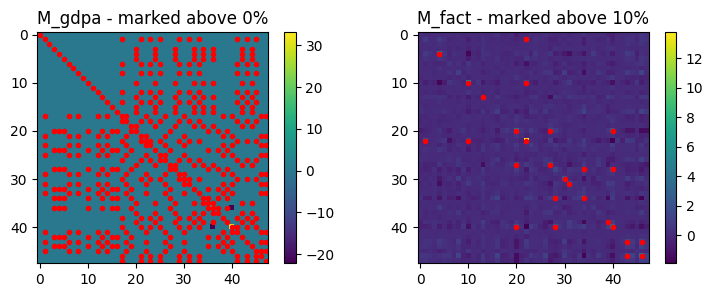

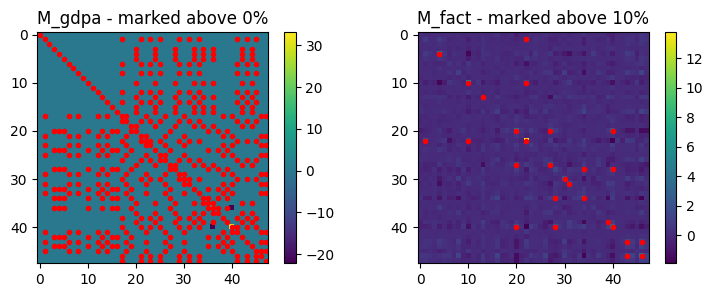

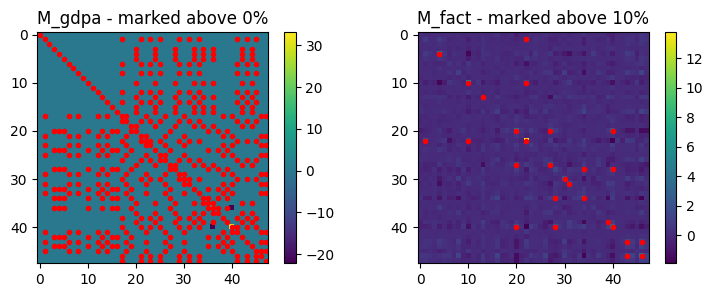

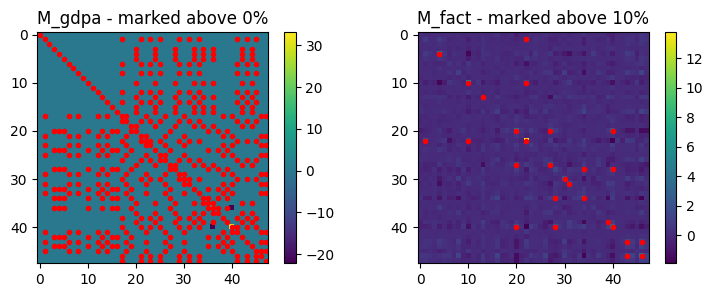

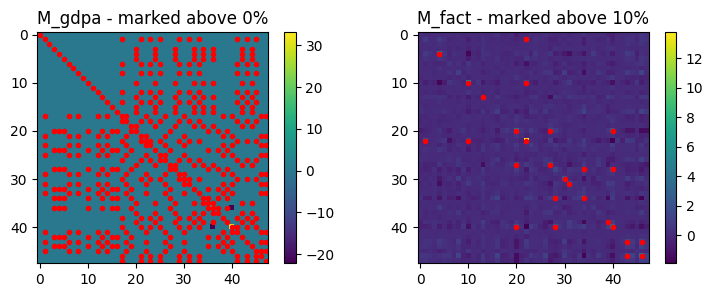

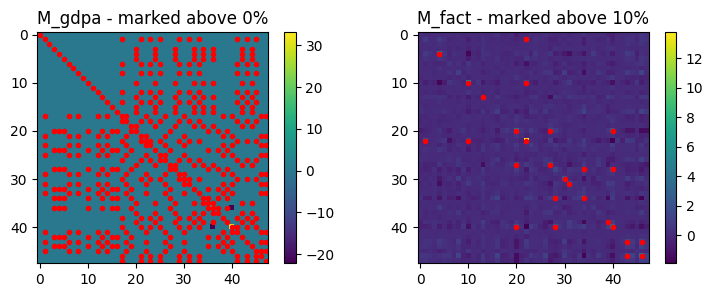

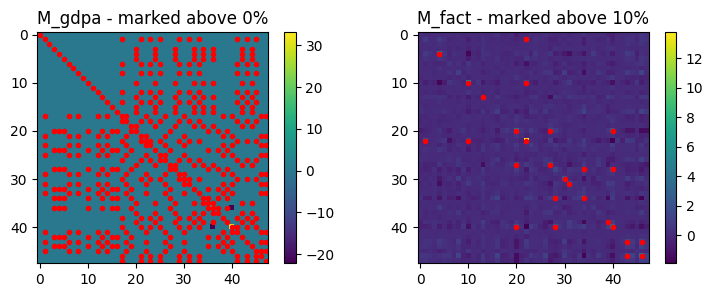

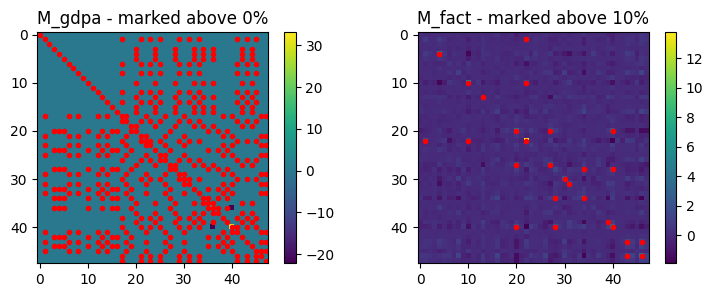

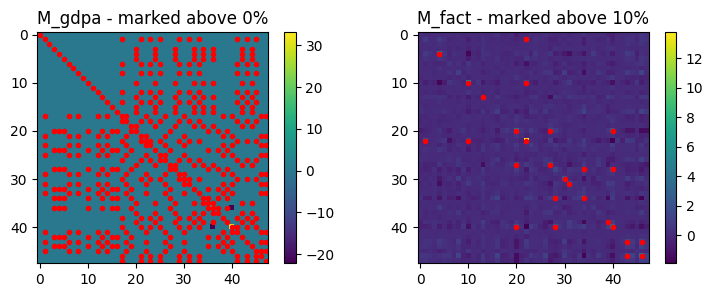

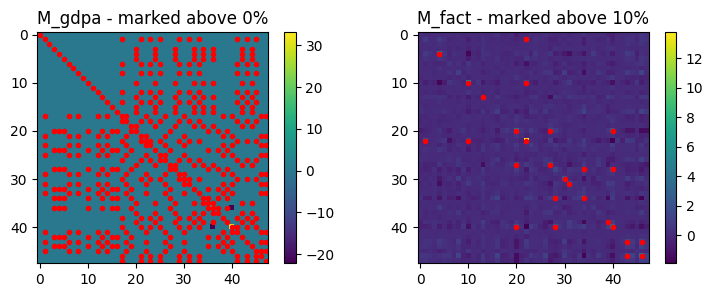

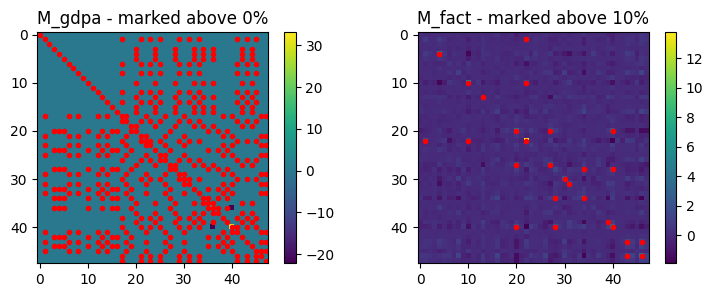

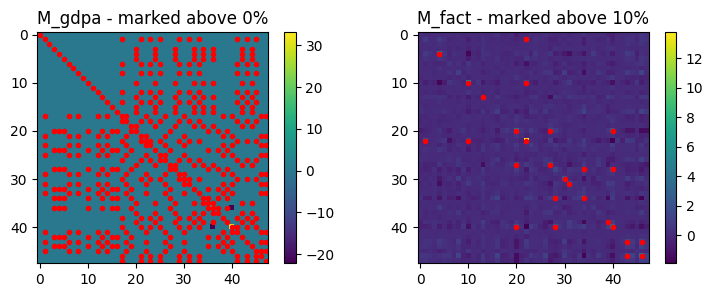

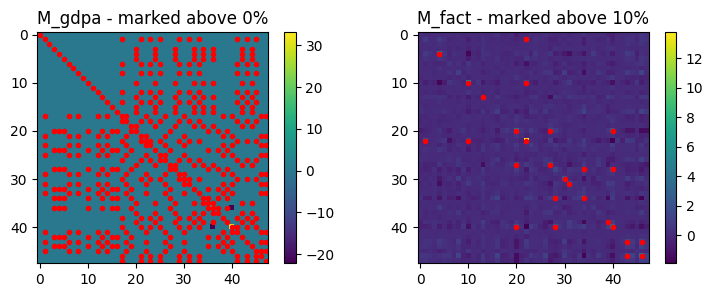

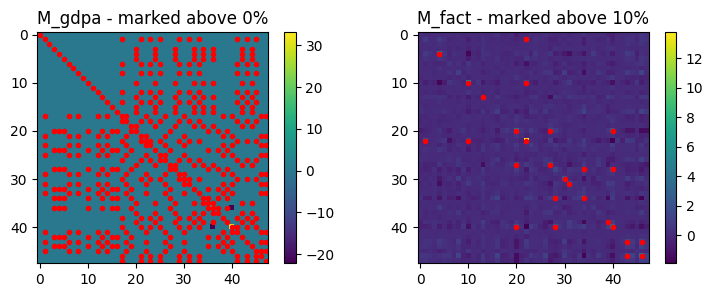

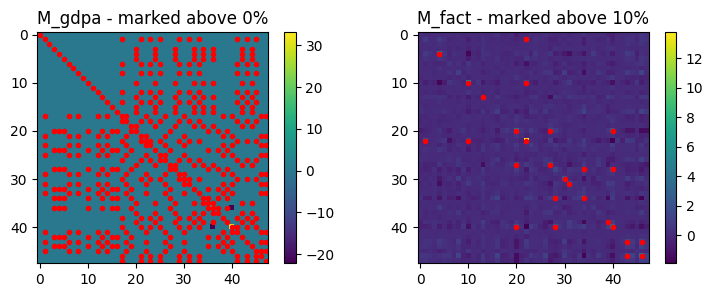

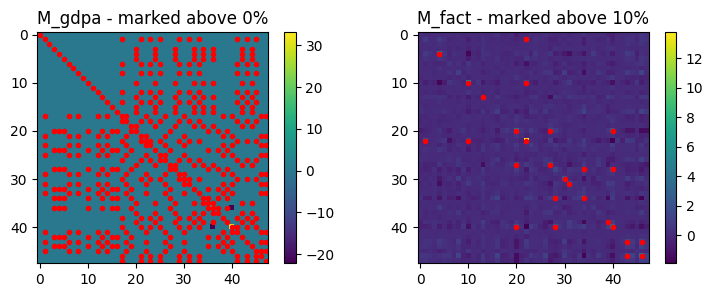

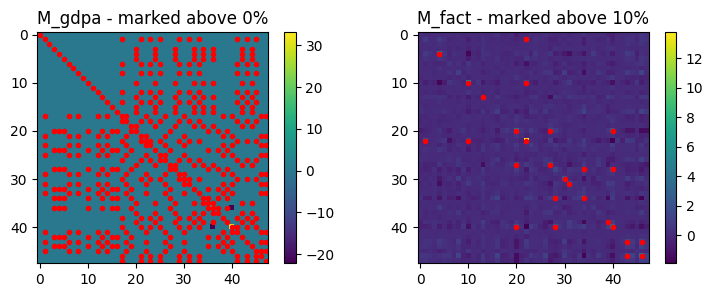

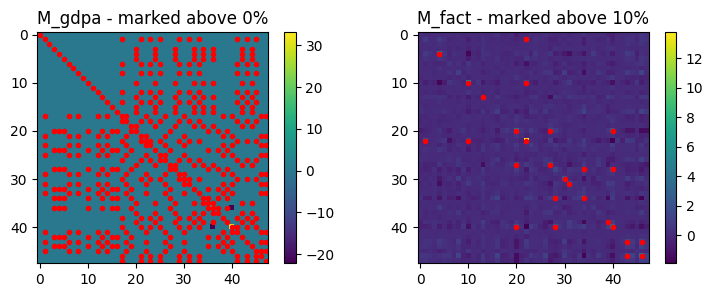

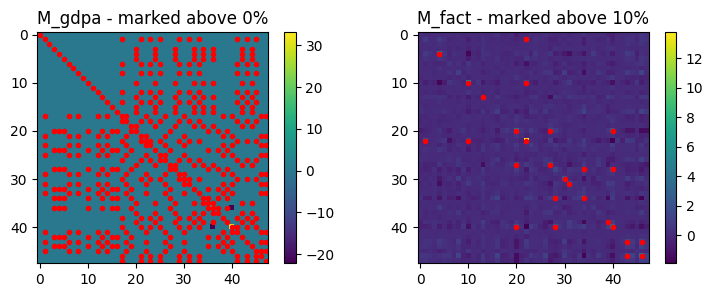

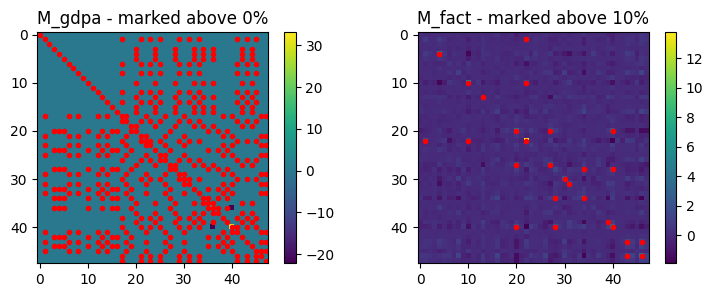

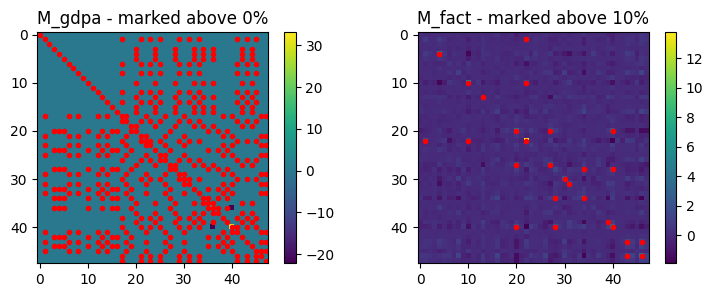

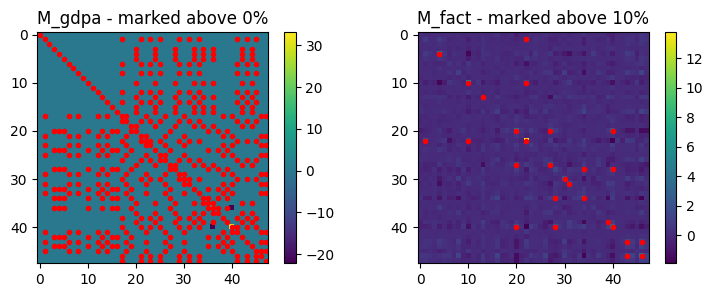

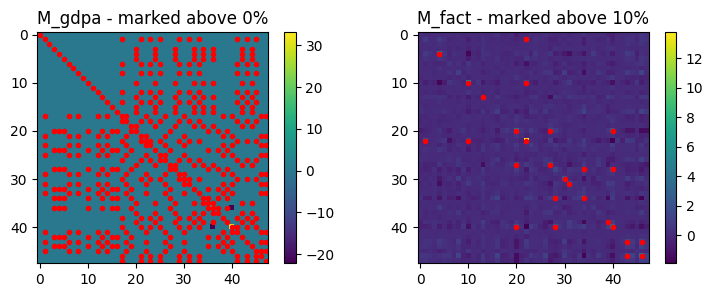

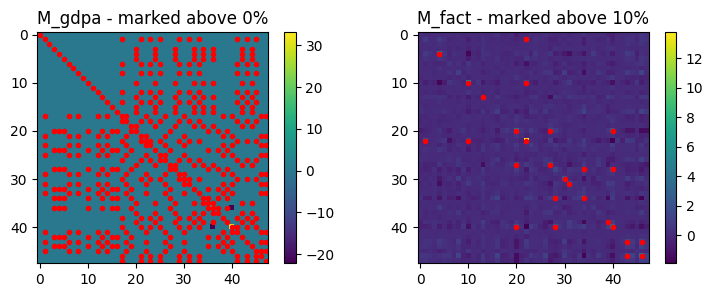

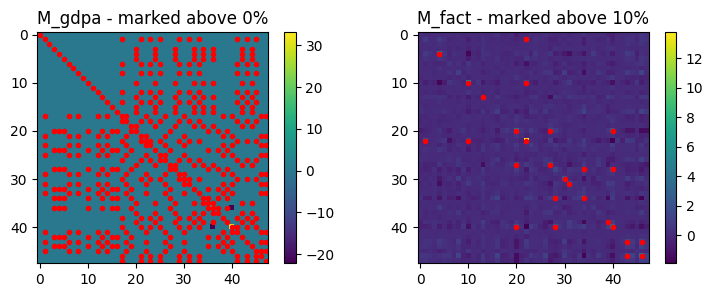

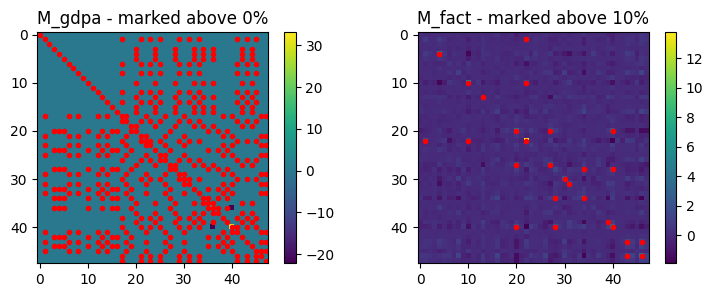

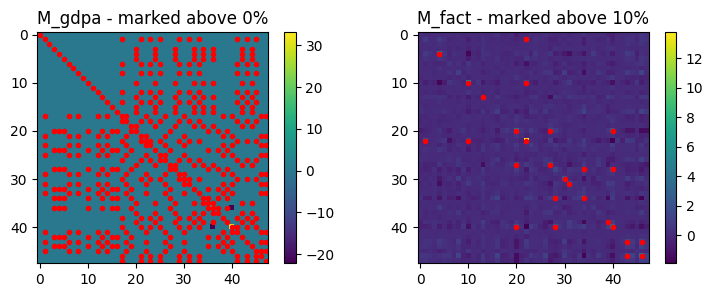

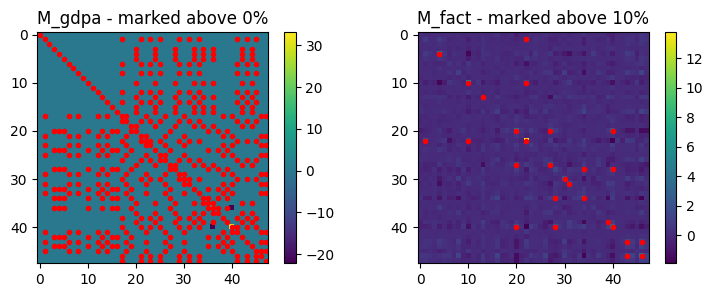

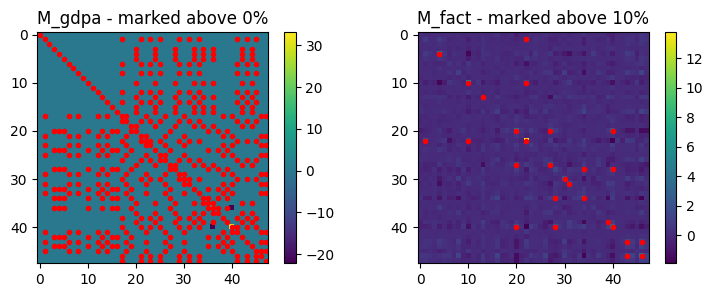

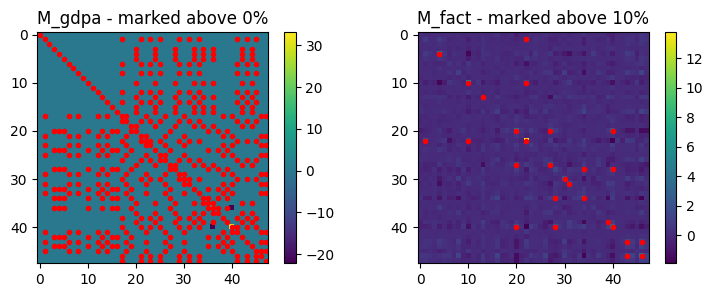

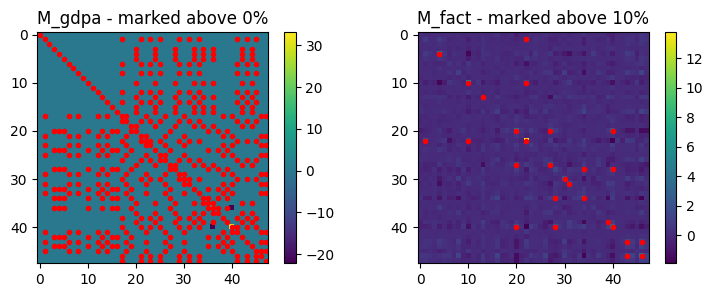

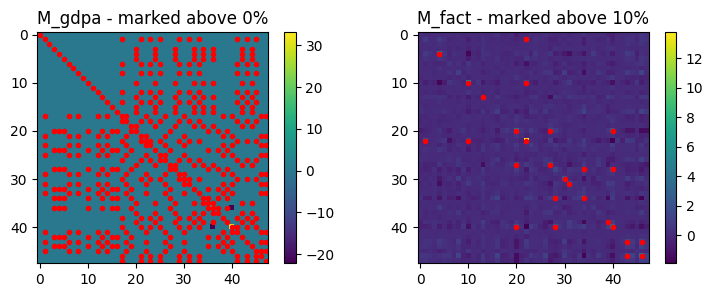

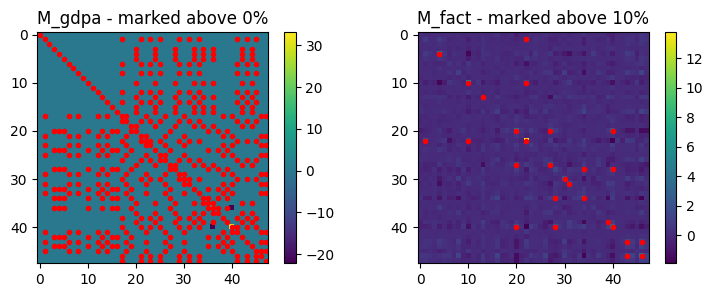

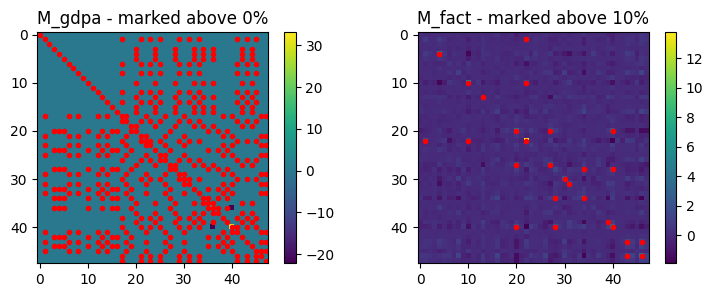

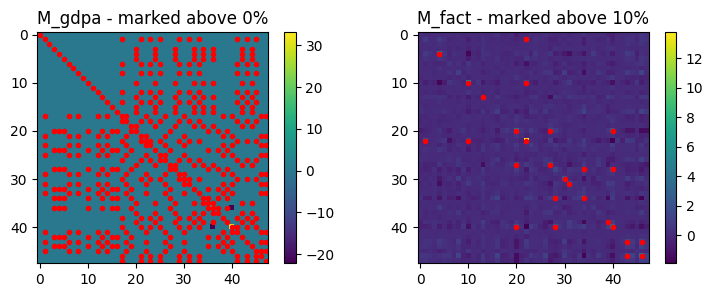

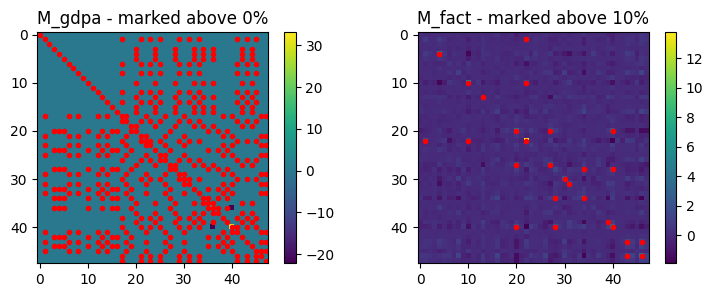

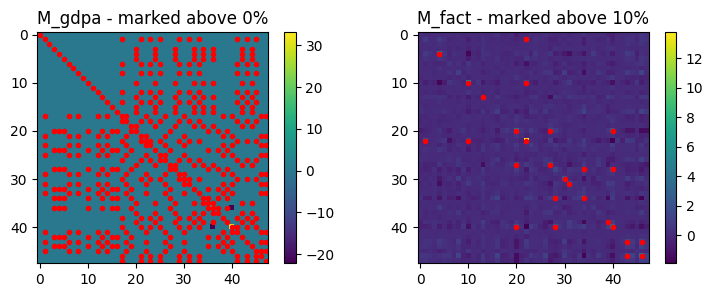

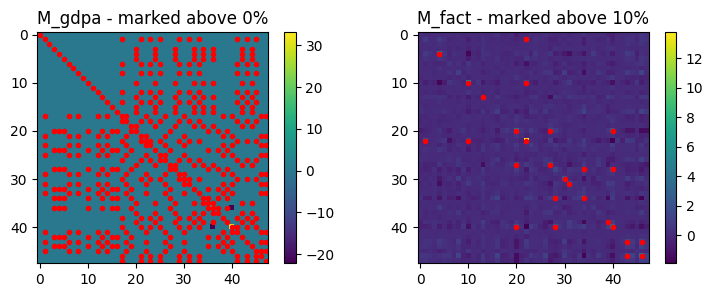

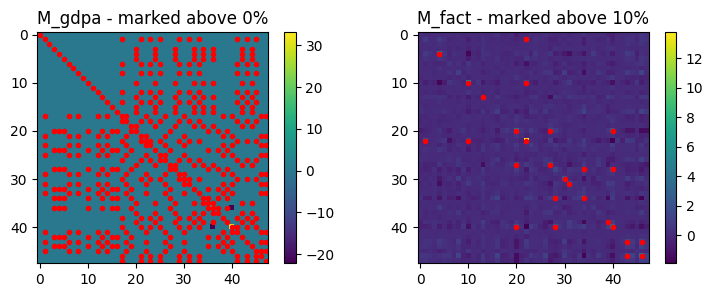

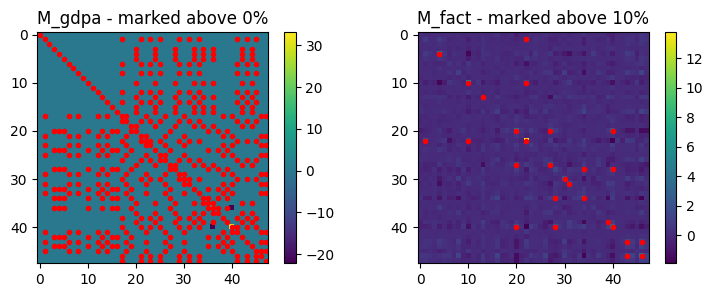

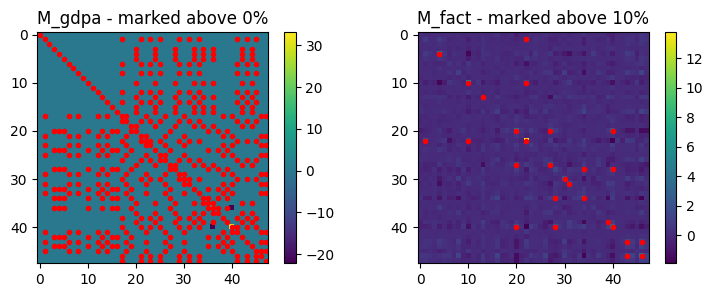

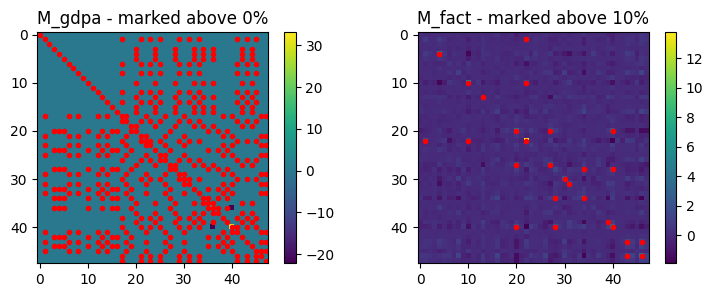

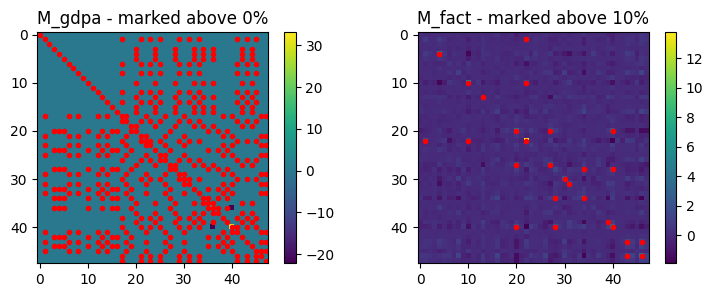

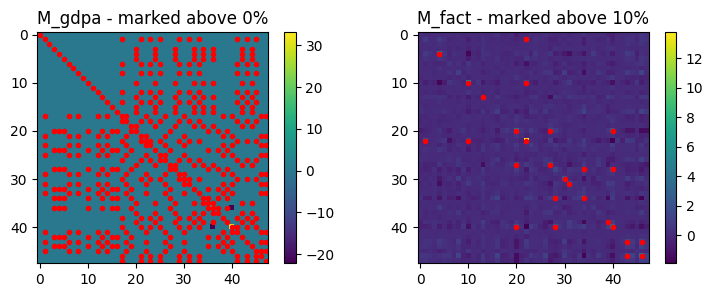

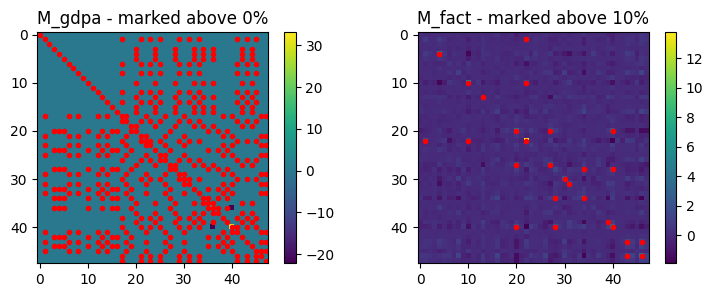

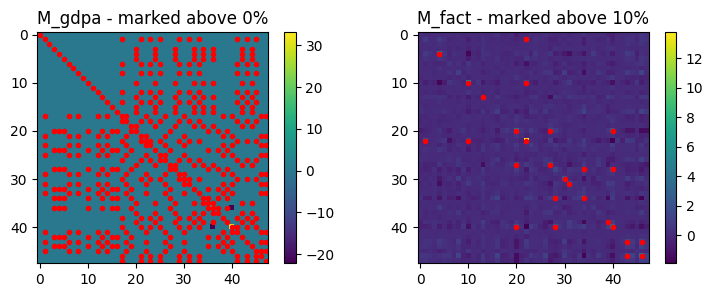

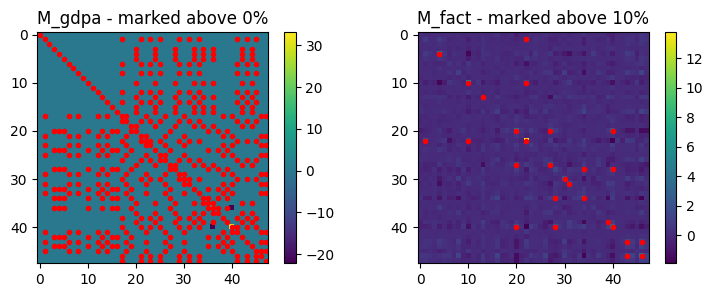

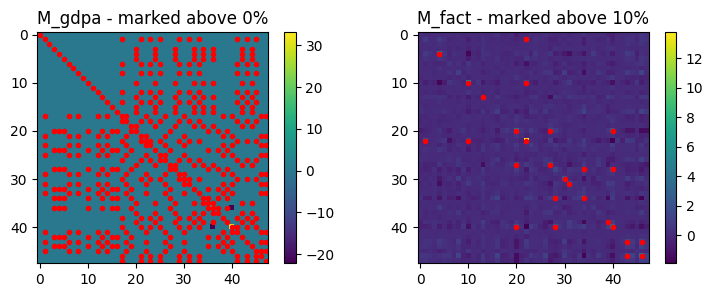

In [41]:
for seed in range(10, 1000, 13):
    data_seed = 123
    val_seed_gdpa = seed
    train_seed_fact = 11
    val_seed_fact = 0
    
    print('\n\nNEW SEED == {}\n\n'.format(seed))
    gdpa_fact_lgrg(data_seed, val_seed_gdpa, train_seed_fact, val_seed_fact)

In [38]:
gamma = 1.0
V = eng.get_objective_variables_ready(train_data['des'], train_data['lbls'].reshape((300,1)), train_data['des'].shape[0], train_data['des'].shape[1], gamma)
V = np.array(V)

loss_gdpa = np.sum(M_gdpa * V.T)
loss_fact = np.sum(M_fact * V.T)

print('GDPA final loss: ', loss_gdpa)
print('GDPA loss with Factorization metric: ', loss_gdpa)

GDPA final loss:  -138461.08962631357
GDPA loss with Factorization metric:  -138461.08962631357


# All in One

starting SGML.
initial objective value = -13245.7029
converged objective value = -138461.0285
minimal eigenvalue of M = 9.9958e-06
done with SGML.
**GDPA:
Elapsed training time = 0.41 sec
Elapsed validation time = 16.93 ms
***
Number of training datapoints: 300
Number of features for each point: 48
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 23466.20
   1: eps = 1.95e-03;  train loss (E) = 18859.83
   2: eps = 3.91e-03;  train loss (E) = 12278.75
   3: eps = 7.81e-03;  train loss (E) = 5844.71
   4: eps = 1.56e-02;  train loss (E) = 3586.85
   5: eps = 7.81e-03;  train loss (E) = 3384.04
   6: eps = 1.56e-02;  train loss (E) = 3345.66
   7: eps = 7.81e-03;  train loss (E) = 3313.80
   8: eps = 3.91e-03;  train loss (E) = 3283.14
   9: eps = 7.81e-03;  train loss (E) = 3280.03
**Factorization:
Elapsed train time = 7.43 sec
Elapsed validation time = 16.62 ms
***
**LogReg:
Elapsed train time = 15.03 ms
Elapsed validation time = 0.52 ms
***
**Comparison:
M_gdpa - Coordinates of element

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


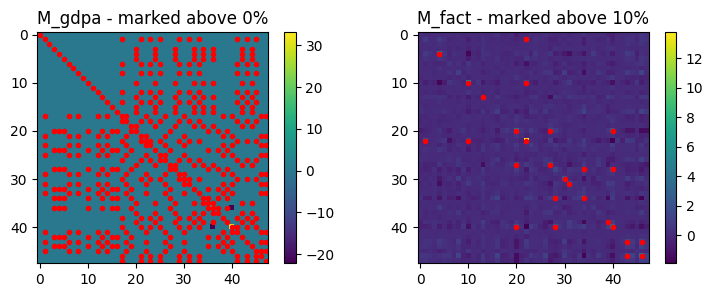

In [33]:
data_seed = 123
val_seed_gdpa = 123
train_seed_fact = 11
val_seed_fact = 0

def transform(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[:, ::100]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

data_params = {'func': dh.datapoint_torch, 'lbl_func': dh.get_labels, 'features_dp': '../../../data/features/slowfast/slowfast_4732/', \
               'spike_data': grouped_data, 'group_id': 0, 'transform': transform}

# get the data
train_num, val_num, train_data, val_data = \
dh.random_train_val_balanced(train_num, val_num, ind_min, ind_max, data_params, seed=data_seed)

## GDPA
# save the dataset on disc for Matlab's use
data_path = '../../../data/fe_exp/cheng_snap/'
savemat(data_path+'data.mat', {'train_des': train_data['des'], 'train_lbls': train_data['lbls']})
time0 = time.time()
M_gdpa = eng.gdpa_fit()
M_gdpa = np.array(M_gdpa)
# graph construction and penalty term parameters
sg_params = {'mu': 30, 'Dt': None, 'Dv': 0, 'Dvt': 2000, \
             'cnstr_method_tt': 'time', 'cnstr_method_vv': 'time', 'cnstr_method_vt': 'time',\
             'train_t': train_data['smpls'], 'val_t': val_data['smpls'], \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }
print('**GDPA:\nElapsed training time = {:.2f} sec'.format(time.time()-time0))
val_acc_gdpa, y_est_gdpa, t_gdpa = sg.get_acc(M_gdpa, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed=val_seed_gdpa, show_edges=False)
print('Elapsed validation time = {:.2f} ms'.format(t_gdpa*1000))
# comparing estimated and real spike locations
val_loc = np.arange(val_num)
val_spikes = val_loc[val_data['lbls']==1]
est_spikes_gdpa = val_loc[y_est_gdpa > 0]
if sum(val_data['lbls']==1) == 0:
    missed_gdpa = 0
else:
    missed_gdpa = sum(np.logical_and(val_data['lbls']==1, y_est_gdpa < 0))/sum(val_data['lbls']==1)
if sum(val_data['lbls']==-1) == 0:
    false_alarm_gdpa = 0
else:
    false_alarm_gdpa = sum(np.logical_and(val_data['lbls']==-1, y_est_gdpa > 0))/sum(val_data['lbls']==-1)
nospk_per = np.sum(val_data['lbls']==-1)/val_num
min_acc = max(nospk_per, 1-nospk_per)
print('***')

## Factorization

# gradient descent parameters
sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
                  'num_its':10, 'check_freq':1, 'print_checks':True, 'Theta0':None, \
                  'force_all_its': True, 'threshold': 0.01}
time0 = time.time()
B_fact, sg_stats_fact = sg.fit_graph(dess=train_data['des'], lbls=train_data['lbls'], graph_params=sg_params, opt_params=sg_opt_params, seed=train_seed_fact)
print('**Factorization:\nElapsed train time = {:.2f} sec'.format(time.time()-time0))
M_fact = B_fact.T @ B_fact
val_acc_fact, y_est_fact, t_fact = sg.get_acc(M_fact, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed=val_seed_fact, show_edges=False)
print('Elapsed validation time = {:.2f} ms'.format(t_fact*1000))
# comparing estimated and real spike locations
est_spikes_fact = val_loc[y_est_fact > 0]
if sum(val_data['lbls']==1) == 0:
    missed_fact = 0
else:
    missed_fact = sum(np.logical_and(val_data['lbls']==1, y_est_fact < 0))/sum(val_data['lbls']==1)
if sum(val_data['lbls']==-1) == 0:
    false_alarm_fact = 0
else:
    false_alarm_fact = sum(np.logical_and(val_data['lbls']==-1, y_est_fact > 0))/sum(val_data['lbls']==-1)
print('***')


## Logistic Regression
# train the model
time0 = time.time()
lgrg = lgrg.fit(train_data['des'], train_data['lbls'])
print('**LogReg:\nElapsed train time = {:.2f} ms'.format((time.time()-time0)*1000))
# validate the model
preds_lgrg = lgrg.predict(val_data['des'])
time0 = time.time()
val_acc_lgrg = lgrg.score(val_data['des'], val_data['lbls'])
print('Elapsed validation time = {:.2f} ms'.format((time.time()-time0)*1000))
est_spikes_lgrg = val_loc[preds_lgrg > 0]
print('***')


## Comparisons
print('**Comparison:')
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.imshow(M_gdpa)
plt.colorbar()
plt.title('GDPA')
# mark elements with high values
thresh = 0
lim = (thresh/100) * np.max(M_gdpa) # marker threshold
f_sz = M_gdpa.shape[0]
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
plt.plot(xloc[M_gdpa > lim],yloc[M_gdpa > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M_gdpa - marked above {}%'.format(thresh))
print('M_gdpa - Coordinates of elements with higher values than {}'.format(lim))
print(list(zip(xloc[M_gdpa > lim],yloc[M_gdpa > lim])))


plt.subplot(1,2,2)
plt.imshow(M_fact)
plt.colorbar()
plt.title('Factorization')
# mark elements with high values
thresh = 10
lim = (thresh/100) * np.max(M_fact) # marker threshold
f_sz = M_fact.shape[0]
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
plt.plot(xloc[M_fact > lim],yloc[M_fact > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M_fact - marked above {}%'.format(thresh))
print('M_fact - Coordinates of elements with higher values than {:.2f}'.format(lim))
print(list(zip(xloc[M_fact > lim],yloc[M_fact > lim])))

print('\nGDPA val acc = {:.2f}%'.format(val_acc_gdpa*100))
print('Factorization val acc = {:.2f}%'.format(val_acc_fact*100))
print('LogReg val acc = {:.2f}%'.format(val_acc_lgrg*100))

print('\nReal spike time bins: ', val_spikes)
print('GDPA estimated spike time bins: ', est_spikes_gdpa)
print('Factorization estimated spike time bins: ', est_spikes_fact)
print('LogReg estimated spike time bins: ', est_spikes_lgrg)

print('\nGDPA missed spikes (/all spikes): {:.2f}%'.format(missed_gdpa*100))
print('Factorization missed spikes (/all spikes): {:.2f}%'.format(missed_fact*100))
print('LogReg missed spikes (/all spikes): {:.2f}%'.format(missed_lgrg*100))

print('\nGDPA false spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_gdpa*100))
print('Factorization false spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_fact*100))
print('LogReg false spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_lgrg*100))

print('\n{:.2f}% of validation points have label {} (= min accuracy)'.format(min_acc*100, -1 if nospk_per > 50 else 1))

In [34]:
gamma = 1.0
V = eng.get_objective_variables_ready(train_data['des'], train_data['lbls'].reshape((train_num,1)), train_data['des'].shape[0], train_data['des'].shape[1], gamma)
V = np.array(V)

In [35]:
loss_gdpa = np.sum(M_gdpa * V.T)
loss_fact = np.sum(M_fact * V.T)

print('GDPA final loss: ', loss_gdpa)
print('GDPA loss with Factorization metric: ', loss_gdpa)

GDPA final loss:  -138461.08962631357
GDPA loss with Factorization metric:  -138461.08962631357


In [53]:
np.sum(M_gdpa == 0)

8034

In [110]:
np.sum(M_fact == 0)

0

In [109]:
24*24

576

# Show statistics